In [229]:
# !pip install kmodes==0.12.2
!pip install xgboost
#pip install simpledbf



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import xgboost as xgb


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
# from kmodes.kprototypes import KPrototypes
from simpledbf import Dbf5

<img src="image-20231010-120042.png" width="" align="" />

# TEM QUE VER

- [x] Distribuição dos clusters muito desigual

- [x] Cluster final vai estar muito grande por falta de caracterização (todos são muito parecidos, independente das variáveis escolhidas)

- [ ] Separar entre perguntas (hipóteses) gerais e específicas

- [x] Limpar o código

- [x] Normalizar população também?

- [x] Rodar otimizacão por score antes de excluir dados correlacionados

- [ ] Ver clusters de cidades que fazem xilogravura

- [ ] Ver se já é aplicado agricultura nas localidades

- [ ] Não se limitar apenas à uma cidade, escolher uma cidade principal e outras proximas

- [x] EXCLUIR GUAMARÉ PELO AMOR DE DEUS

# Perguntas

- [ ] Faz sentido clusterizar com dados antigos e analisar com dados atuais?

# Importação dos dados

Foi realizada uma análise preliminar nos dados ofertados, selecionando-se apenas as variáveis mais relevantes de cada conjunto de dados segundo a equipe.

In [231]:
# Carregando os datasets municipios gerais
original_municipios_df = pd.read_csv('./Data/municipios.csv')
municipios_df = original_municipios_df.copy()
original_municipios_df

codigo_ibge                 nome  latitude  longitude  codigo_uf
0         5200050      Abadia de Goiás -16.75730   -49.4412         52
1         3100104  Abadia dos Dourados -18.48310   -47.3916         31
2         5200100            Abadiânia -16.19700   -48.7057         52
3         3100203               Abaeté -19.15510   -45.4444         31
4         1500107           Abaetetuba  -1.72183   -48.8788         15
...           ...                  ...       ...        ...        ...
5565      2933604          Xique-Xique -10.82300   -42.7245         29
5566      2517407               Zabelê  -8.07901   -37.1057         25
5567      3557154             Zacarias -21.05060   -50.0552         35
5568      2114007              Zé Doca  -3.27014   -45.6553         21
5569      4219853               Zortéa -27.45210   -51.5520         42

[5570 rows x 5 columns]

In [232]:
# Dataset de municipios apenas do semiárido
original_municipios_semiarido_df = pd.read_csv('./Data/municipios_semiarido.csv')
municipios_semiarido_df = original_municipios_semiarido_df.copy()
mask = municipios_semiarido_df['Município'].isin(['GUAMARÉ', 'PAULISTA'])
municipios_semiarido_df = municipios_semiarido_df[~mask]
original_municipios_semiarido_df

Cod IBGE  UF             Município  População Estimada - 2017
0      2700102  AL           ÁGUA BRANCA                      20467
1      2700300  AL             ARAPIRACA                     234185
2      2700706  AL               BATALHA                      18757
3      2700904  AL            BELO MONTE                       6797
4      2701209  AL           CACIMBINHAS                      10897
...        ...  ..                   ...                        ...
1257   2806008  SE          RIBEIRÓPOLIS                      18641
1258   2807006  SE  SÃO MIGUEL DO ALEIXO                       3943
1259   2807105  SE            SIMÃO DIAS                      40838
1260   2807303  SE                 TELHA                       3221
1261   2807402  SE        TOBIAS BARRETO                      52156

[1262 rows x 4 columns]

In [233]:
# Dataset de dados administrativos
original_administrativos_df = pd.read_csv('./Data/administrativos_total_filtrado.csv')
administrativos_total_df = original_administrativos_df.copy()
# Filtra apenas no ano de 2017
mask = administrativos_total_df['ANO'].isin([2013])
administrativos_total_df = administrativos_total_df[mask].reset_index(drop=True, inplace=False)
administrativos_total_df

ANO    IBGE7                        NOME  TTREVA_EF_TOTAL  \
0     2013  1100015  Alta Floresta D&apos;Oeste              3.4   
1     2013  1100023                   Ariquemes              3.0   
2     2013  1100031                      Cabixi              1.5   
3     2013  1100049                      Cacoal              2.4   
4     2013  1100056                  Cerejeiras              2.5   
...    ...      ...                         ...              ...   
5565  2013  5222005                  Vianópolis              2.9   
5566  2013  5222054              Vicentinópolis              4.6   
5567  2013  5222203                    Vila Boa              3.4   
5568  2013  5222302               Vila Propício              NaN   
5569  2013  5300108                    Brasília              NaN   

      TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  TXCOBPLP  PINTERDRSAI  \
0                 9.2    18.32         4.35     12.55        11.12   
1                 9.1    11.49         4.71      7.97         2.59   
2                 6.9    13.51         3.54      3.48         7.64   
3                 9.3    15.19         4.41      8.68         3.68   
4                 8.5    11.07         5.60      3.49        15.28   
...               ...      ...          ...       ...          ...   
5565             13.1    18.29         4.46      6.19        15.19   
5566             13.3    27.78         6.43      6.30         7.16   
5567             10.2    13.33         4.38      0.67         6.63   
5568              NaN     0.00         4.40      0.90         4.76   
5569              NaN    12.73         4.09     29.63         1.05   

      REN_PIBPC_D  REN_PVAAGR  REN_PVAIND  POP_TOT  
0           11.10       34.16        6.27    25728  
1           14.88        5.79       22.04   101269  
2           12.42       41.45        3.70     6495  
3           13.97       11.02       10.99    85863  
4           16.39       15.17        6.68    18041  
...           ...         ...         ...      ...  
5565        18.47       36.72       10.18    13227  
5566        27.37       44.75       14.24     7933  
5567        16.47       38.11       13.20     5246  
5568        21.92       59.97       10.22     5460  
5569        52.77        0.41        6.43  2789761  

[5570 rows x 13 columns]

In [234]:
# Dataset de dados do censo
censo_df = pd.read_csv('./Data/censo.csv',delimiter=';')
mask = ["ANO", 
        "Codmun7", 
        "MORT1", "MORT5", 
        "SOBRE40", "SOBRE60", "E_ANOSESTUDO", 
        "T_ANALF11A14", "T_ANALF15A17", "T_ANALF15M", "T_ANALF18A24", "T_ANALF18M", "T_ANALF25A29", "T_ANALF25M", 
        "GINI", "PIND", "PINDCRI", "PMPOB", "PMPOBCRI", "PPOB", "PPOBCRI", 
        "PREN10RICOS", "PREN20", "PREN20RICOS", "PREN40", "PREN60", "PREN80", 
        "RDPC", "RDPCT", "RIND", "RMPOB", "RPOB", #"RDPC1", "RDPC10", "RDPC2", "RDPC3", "RDPC4", "RDPC5", 
        "THEIL", "CPR", "EMP", "P_AGRO", "P_COM", "P_CONSTR", "P_TRANSF", "P_EXTR",
        "REN0", "REN1", "RENOCUP", #"REN2", "REN3", "REN5",  
        "T_NESTUDA_NTRAB_MMEIO", "T_OCUPDESLOC_1", "T_RMAXIDOSO", "T_SLUZ", 
        "IDHM", "IDHM_E", "IDHM_L", "IDHM_R", "PEA18M",] #"PEA", "PEA1014", "PEA1517",  ]
# NÃO APAGAR "HOMEM0A4", "HOMEM10A14", "HOMEM15A19", "HOMEM20A24", "HOMEM25A29", "HOMEM30A34", "HOMEM35A39", "HOMEM40A44", "HOMEM45A49", "HOMEM50A54", "HOMEM55A59", "HOMEM5A9", "HOMEM60A64", "HOMEM65A69", "HOMEM70A74", "HOMEM75A79", "HOMEMTOT", "HOMENS80", "MULH0A4", "MULH10A14", "MULH15A19", "MULH20A24", "MULH25A29", "MULH30A34", "MULH35A39", "MULH40A44", "MULH45A49", "MULH50A54", "MULH55A59", "MULH5A9", "MULH60A64", "MULH65A69", "MULH70A74", "MULH75A79", "MULHER80", "MULHERTOT",
censo_df = censo_df[mask]
censo_df = censo_df[censo_df["ANO"] == 2010]
censo_df

ANO  Codmun7  MORT1  MORT5  SOBRE40  SOBRE60  E_ANOSESTUDO  \
11130  2010  1100015  23.80  25.49    94.50    83.18          8.67   
11131  2010  1100023  19.20  20.53    96.12    87.69          9.18   
11132  2010  1100031  24.80  26.58    94.27    82.57         10.09   
11133  2010  1100049  14.30  15.38    96.41    88.56          9.74   
11134  2010  1100056  18.10  19.42    95.78    86.72         10.22   
...     ...      ...    ...    ...      ...      ...           ...   
16690  2010  5222005  14.40  17.04    93.03    82.02         10.11   
16691  2010  5222054  15.70  18.51    92.47    80.75         10.07   
16692  2010  5222203  14.50  17.09    93.02    81.98         10.49   
16693  2010  5222302  15.90  18.80    92.36    80.50          9.46   
16694  2010  5300108  14.01  15.85    94.57    86.19          9.87   

       T_ANALF11A14  T_ANALF15A17  T_ANALF15M  ...  RENOCUP  \
11130          1.22          1.52       11.99  ...   950.08   
11131          1.55          1.09        7.90  ...  1274.11   
11132          0.62          1.06       13.63  ...   827.86   
11133          1.01          0.80        8.29  ...  1277.37   
11134          1.14          0.75       10.29  ...   926.57   
...             ...           ...         ...  ...      ...   
16690          0.66          0.74        7.97  ...  1110.12   
16691          1.22          1.32       12.68  ...  1114.20   
16692          3.60          1.56       15.88  ...   792.05   
16693          4.15          1.99       19.25  ...   666.51   
16694          1.10          0.80        3.47  ...  2581.69   

       T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
11130                  16.12            1.15         2.20    6.02  0.641   
11131                   9.67            0.16         1.40    1.42  0.702   
11132                  16.59            0.65         3.10    3.64  0.650   
11133                   9.64            0.43         1.84    1.11  0.718   
11134                  10.16            0.38         1.43    1.15  0.692   
...                      ...             ...          ...     ...    ...   
16690                   5.63            1.23         1.33    0.17  0.712   
16691                  10.47            1.55         1.25    0.30  0.684   
16692                  21.64            1.74         3.81    0.22  0.647   
16693                  11.92            0.20         4.48    2.41  0.634   
16694                   5.13            1.40         0.71    0.09  0.824   

       IDHM_E  IDHM_L  IDHM_R     PEA18M  
11130   0.526   0.763   0.657     9928.0  
11131   0.600   0.806   0.716    42801.0  
11132   0.559   0.757   0.650     2648.0  
11133   0.620   0.821   0.727    37317.0  
11134   0.602   0.799   0.688     8133.0  
...       ...     ...     ...        ...  
16690   0.622   0.818   0.710     6201.0  
16691   0.562   0.804   0.707     3663.0  
16692   0.534   0.818   0.619     1962.0  
16693   0.505   0.802   0.629     2076.0  
16694   0.742   0.873   0.863  1361053.0  

[5565 rows x 52 columns]

# Tratamento dos dados

## Merging

In [235]:
# Precisamos converter todos os nomes para lowercase para o merge funcionar
municipios_df['nome'] = municipios_df['nome'].str.upper()
# municipios_semiarido_df['Município'] = municipios_semiarido_df['Município'].str.upper()
# administrativos_total_df['NOME'] = administrativos_total_df['NOME'].str.upper()
# censo_df['Município'] = censo_df['Município'].str.upper()

# Juntando os datasets
merged_municipios_df = pd.merge(municipios_df, municipios_semiarido_df, left_on='codigo_ibge', right_on='Cod IBGE')
merged_municipios_df = pd.merge(merged_municipios_df, administrativos_total_df, left_on='codigo_ibge', right_on='IBGE7')
merged_municipios_df = pd.merge(merged_municipios_df, censo_df, left_on='codigo_ibge', right_on='Codmun7')
merged_municipios_df.drop(['Município', 'Cod IBGE', 'NOME', 'População Estimada - 2017', 'IBGE7', 'ANO_x', 'ANO_y', 'Codmun7'], axis=1, inplace=True)
# merged_municipios_df.drop(['Município', 'Cod IBGE', 'NOME', 'População Estimada - 2017', 'IBGE7'], axis=1, inplace=True)
# merged_municipios_df['População Estimada - 2017'] = merged_municipios_df['População Estimada - 2017'].astype(int)
original_merged_df = merged_municipios_df.copy()
original_merged_df

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3         2300150      ACARAPE  -4.22083   -38.7055         23  CE   
4         2300200       ACARAÚ  -2.88769   -40.1183         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  RENOCUP  \
0                 2.4              5.9    17.24         5.23  ...   410.96   
1                 4.4             16.5    55.56         5.58  ...   337.76   
2                 3.5             11.5     6.90         3.74  ...   389.08   
3                 4.3             16.0    20.58         5.18  ...   513.03   
4                 3.1             10.3    17.56         5.12  ...   457.36   
...               ...              ...      ...          ...  ...      ...   
1255              4.8              8.3     7.75         6.31  ...   428.36   
1256              2.2             18.5     0.00         4.36  ...   273.38   
1257              4.7              6.4    21.39         4.74  ...   492.12   
1258              6.1             11.7    17.07         5.24  ...   490.83   
1259              1.1             11.3     0.00         5.07  ...   297.81   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                     30.48            1.61         8.04    0.64  0.628   
1                     15.61            3.86         5.35    2.31  0.603   
2                     25.37            2.00         8.76    9.17  0.575   
3                     29.18            1.25         5.39    0.57  0.606   
4                     27.93            1.09         5.80    4.42  0.601   
...                     ...             ...          ...     ...    ...   
1255                  19.28            2.99         4.09    3.87  0.587   
1256                  27.82            0.17         6.97    3.21  0.544   
1257                  26.37            1.87         4.08   14.26  0.600   
1258                  18.49            3.18         6.14    4.86  0.585   
1259                  15.63            0.00         1.80    0.68  0.623   

      IDHM_E  IDHM_L  IDHM_R   PEA18M  
0      0.612   0.748   0.540   3481.0  
1      0.510   0.746   0.577   3455.0  
2      0.460   0.776   0.533   6123.0  
3      0.562   0.709   0.559   5181.0  
4      0.517   0.758   0.554  20898.0  
...      ...     ...     ...      ...  
1255   0.479   0.737   0.573   3768.0  
1256   0.443   0.708   0.513   1359.0  
1257   0.498   0.764   0.569   4806.0  
1258   0.479   0.741   0.563  16888.0  
1259   0.587   0.725   0.567   1014.0  

[1260 rows x 66 columns]

## Feature scalling

Todos esses algoritmos baseados em distância são afetados pela escala das variáveis. Como temos um problema de clusterização, e nosso dados não possuim a mesma unidade de medida, é necessário realizar uma normalização dos mesmos para que o algorítmo não seja afetado pela magnitude dos valores.

In [236]:
# Separa as colunas que não serão normalizadas
_columns = [
    "codigo_ibge",
    "nome",
    "codigo_uf",
    "UF",
    "latitude",
    "longitude",
    "POP_TOT",
]

data_to_norm = merged_municipios_df.drop(columns=_columns, inplace=False)
data_aux = merged_municipios_df[_columns]

# Normaliza os dados com z-score
scaler_mean = data_to_norm.values.mean(axis=0)
scaler_std = data_to_norm.values.std(axis=0)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_to_norm)

# Recria o dataframe normalizado
normalized_data = pd.DataFrame(normalized_data, columns=data_to_norm.columns)
merged_municipios_df = data_aux.join(normalized_data)
merged_municipios_df


codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1255      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1256      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1257      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1258      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1259      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...   RENOCUP  \
0           -0.996544        -1.282296  0.078093  ... -0.187046   
1            0.088013         1.032209  3.083255  ... -0.686596   
2           -0.400038        -0.059539 -0.732799  ... -0.336365   
3            0.033785         0.923034  0.340025  ...  0.509527   
4           -0.616949        -0.321558  0.103188  ...  0.129609   
...               ...              ...       ...  ...       ...   
1255         0.304924        -0.758257 -0.666139  ... -0.068300   
1256        -1.104999         1.468908 -1.273916  ... -1.125955   
1257         0.250696        -1.173121  0.403548  ...  0.366828   
1258         1.009885        -0.015869  0.064761  ...  0.358024   
1259        -1.701505        -0.103209 -1.273916  ... -0.959233   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO    T_SLUZ      IDHM  \
0                  1.468799       -0.164908     1.214542 -0.510959  0.936835   
1                 -1.330816        1.613053    -0.278413 -0.272445  0.294636   
2                  0.506726        0.143272     1.614144  0.707317 -0.424626   
3                  1.224045       -0.449382    -0.256213 -0.520956  0.371700   
4                  0.988704       -0.575815    -0.028662  0.028910  0.243261   
...                     ...             ...          ...       ...       ...   
1255              -0.639855        0.925575    -0.977715 -0.049642 -0.116370   
1256               0.967994       -1.302804     0.620690 -0.143905 -1.220951   
1257               0.694998        0.040545    -0.983265  1.434283  0.217573   
1258              -0.788591        1.075714     0.160039  0.091752 -0.167746   
1259              -1.327051       -1.437139    -2.248669 -0.505246  0.808395   

        IDHM_E    IDHM_L    IDHM_R    PEA18M  
0     1.957374 -0.320379 -0.585246 -0.253851  
1     0.341287 -0.388677  0.387452 -0.255242  
2    -0.450912  0.635797 -0.769270 -0.112445  
3     1.165174 -1.652195 -0.085753 -0.162863  
4     0.452195  0.021113 -0.217198  0.678343  
...        ...       ...       ...       ...  
1255 -0.149877 -0.696019  0.282295 -0.238490  
1256 -0.720260 -1.686344 -1.295052 -0.367425  
1257  0.151159  0.226008  0.177139 -0.182934  
1258 -0.149877 -0.559423  0.019404  0.463720  
1259  1.561274 -1.105809  0.124560 -0.385890  

[1260 rows x 66 columns]

## Missing values

Algumas cidades não possuem todos os dados utilizados nas análises, por isso, precisaram ser excluídas para manter o projeto data driven.

In [237]:
# df_nulls = pd.DataFrame(merged_municipios_df.isnull().sum(), columns=['Number of Missing Values'])
# df_nulls['% Missing'] = merged_municipios_df.isnull().sum() * 100 / len(merged_municipios_df)
# display(df_nulls)

# Exclui municipios com dados faltando
display(merged_municipios_df.isnull().sum())
merged_municipios_df.dropna(inplace=True)
merged_municipios_df.reset_index(drop=True, inplace=True)
merged_municipios_df

codigo_ibge    0
nome           0
codigo_uf      0
UF             0
latitude       0
              ..
IDHM           0
IDHM_E         0
IDHM_L         0
IDHM_R         0
PEA18M         0
Length: 66, dtype: int64

codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...   RENOCUP  \
0           -0.996544        -1.282296  0.078093  ... -0.187046   
1            0.088013         1.032209  3.083255  ... -0.686596   
2           -0.400038        -0.059539 -0.732799  ... -0.336365   
3            0.033785         0.923034  0.340025  ...  0.509527   
4           -0.616949        -0.321558  0.103188  ...  0.129609   
...               ...              ...       ...  ...       ...   
1227         0.304924        -0.758257 -0.666139  ... -0.068300   
1228        -1.104999         1.468908 -1.273916  ... -1.125955   
1229         0.250696        -1.173121  0.403548  ...  0.366828   
1230         1.009885        -0.015869  0.064761  ...  0.358024   
1231        -1.701505        -0.103209 -1.273916  ... -0.959233   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO    T_SLUZ      IDHM  \
0                  1.468799       -0.164908     1.214542 -0.510959  0.936835   
1                 -1.330816        1.613053    -0.278413 -0.272445  0.294636   
2                  0.506726        0.143272     1.614144  0.707317 -0.424626   
3                  1.224045       -0.449382    -0.256213 -0.520956  0.371700   
4                  0.988704       -0.575815    -0.028662  0.028910  0.243261   
...                     ...             ...          ...       ...       ...   
1227              -0.639855        0.925575    -0.977715 -0.049642 -0.116370   
1228               0.967994       -1.302804     0.620690 -0.143905 -1.220951   
1229               0.694998        0.040545    -0.983265  1.434283  0.217573   
1230              -0.788591        1.075714     0.160039  0.091752 -0.167746   
1231              -1.327051       -1.437139    -2.248669 -0.505246  0.808395   

        IDHM_E    IDHM_L    IDHM_R    PEA18M  
0     1.957374 -0.320379 -0.585246 -0.253851  
1     0.341287 -0.388677  0.387452 -0.255242  
2    -0.450912  0.635797 -0.769270 -0.112445  
3     1.165174 -1.652195 -0.085753 -0.162863  
4     0.452195  0.021113 -0.217198  0.678343  
...        ...       ...       ...       ...  
1227 -0.149877 -0.696019  0.282295 -0.238490  
1228 -0.720260 -1.686344 -1.295052 -0.367425  
1229  0.151159  0.226008  0.177139 -0.182934  
1230 -0.149877 -0.559423  0.019404  0.463720  
1231  1.561274 -1.105809  0.124560 -0.385890  

[1232 rows x 66 columns]

In [92]:
# Plot geográfico
fig = px.scatter_mapbox(merged_municipios_df, lat='latitude', lon='longitude', 
                        hover_name='nome', size='POP_TOT', color='UF',
                        mapbox_style='stamen-toner', center=dict(lat=-12.83, lon=-36.49), zoom=4.5)
# fig.update_geos(
#     resolution=50,
#     showcoastlines=True, coastlinecolor="RebeccaPurple",
#     showland=True, landcolor="LightGreen",
#     showocean=True, oceancolor="LightBlue",
#     showlakes=False, lakecolor="Blue",
#     showrivers=True, rivercolor="Blue",
#     scope="south america",
#     mapbox_style="stamen-terrain"
# )

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Agrupamento de indivíduos

## Por população

### Otimização de clusters

> Aplicação do método do cotovelo:

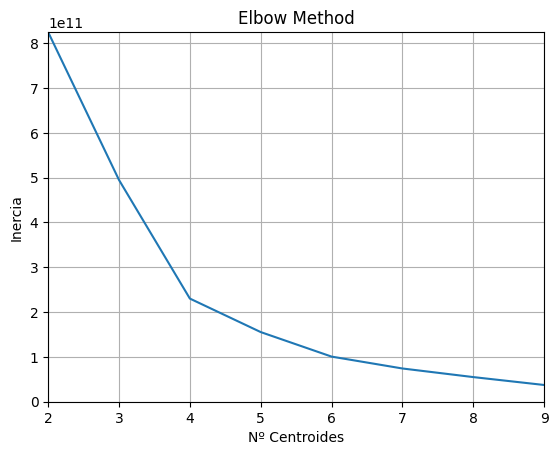

In [93]:
municipios_cluster_array = merged_municipios_df['POP_TOT'].values.reshape(-1,1)

# Determinação do número de centroides pelo método do cotovelo
centroids_max = 10
clusters_list = []
losses = []
for i in range(2,centroids_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', verbose=0, max_iter=30)
    # kproto = KPrototypes(n_clusters=i, verbose=0, max_iter=30)
    clusters = kmeans.fit_predict(municipios_cluster_array)
    losses.append(kmeans.inertia_)

plt.plot(range(2,centroids_max), losses, color='tab:blue')
plt.xlabel('Nº Centroides')
plt.ylabel('Inercia')
plt.title('Elbow Method')
plt.xlim([2,9])
plt.ylim([0, max(losses)])
plt.grid()

### Clusterização

In [94]:
n_clusters = 4

In [95]:
# n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(municipios_cluster_array)

centroids = kmeans.cluster_centers_
print(f'Silhouette Score: {silhouette_score(municipios_cluster_array, clusters)}')

Silhouette Score: 0.755494467136706


In [96]:
merged_municipios_df['cluster'] = clusters.astype(str)
merged_municipios_df

codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1255      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1256      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1257      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1258      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1259      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...  T_NESTUDA_NTRAB_MMEIO  \
0           -0.996544        -1.282296  0.078093  ...               1.468799   
1            0.088013         1.032209  3.083255  ...              -1.330816   
2           -0.400038        -0.059539 -0.732799  ...               0.506726   
3            0.033785         0.923034  0.340025  ...               1.224045   
4           -0.616949        -0.321558  0.103188  ...               0.988704   
...               ...              ...       ...  ...                    ...   
1255         0.304924        -0.758257 -0.666139  ...              -0.639855   
1256        -1.104999         1.468908 -1.273916  ...               0.967994   
1257         0.250696        -1.173121  0.403548  ...               0.694998   
1258         1.009885        -0.015869  0.064761  ...              -0.788591   
1259        -1.701505        -0.103209 -1.273916  ...              -1.327051   

      T_OCUPDESLOC_1  T_RMAXIDOSO    T_SLUZ      IDHM    IDHM_E    IDHM_L  \
0          -0.164908     1.214542 -0.510959  0.936835  1.957374 -0.320379   
1           1.613053    -0.278413 -0.272445  0.294636  0.341287 -0.388677   
2           0.143272     1.614144  0.707317 -0.424626 -0.450912  0.635797   
3          -0.449382    -0.256213 -0.520956  0.371700  1.165174 -1.652195   
4          -0.575815    -0.028662  0.028910  0.243261  0.452195  0.021113   
...              ...          ...       ...       ...       ...       ...   
1255        0.925575    -0.977715 -0.049642 -0.116370 -0.149877 -0.696019   
1256       -1.302804     0.620690 -0.143905 -1.220951 -0.720260 -1.686344   
1257        0.040545    -0.983265  1.434283  0.217573  0.151159  0.226008   
1258        1.075714     0.160039  0.091752 -0.167746 -0.149877 -0.559423   
1259       -1.437139    -2.248669 -0.505246  0.808395  1.561274 -1.105809   

        IDHM_R    PEA18M  cluster  
0    -0.585246 -0.253851        0  
1     0.387452 -0.255242        0  
2    -0.769270 -0.112445        0  
3    -0.085753 -0.162863        0  
4    -0.217198  0.678343        2  
...        ...       ...      ...  
1255  0.282295 -0.238490        0  
1256 -1.295052 -0.367425        0  
1257  0.177139 -0.182934        0  
1258  0.019404  0.463720        2  
1259  0.124560 -0.385890        0  

[1232 rows x 67 columns]

In [97]:
fig = px.scatter_mapbox(
    merged_municipios_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    size='POP_TOT',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

> Através da itentificação dos clusters mais populosos, podemos reduzir o número total de municípios:

In [98]:
# Identifica clusters mais populosos
mean_pop = []
for i in range(n_clusters):
    mask = merged_municipios_df['cluster'].isin([str(i)])
    _len = merged_municipios_df[mask]['POP_TOT'].shape[0]
    _val = sum(merged_municipios_df[mask]['POP_TOT'].values)
    # Lista contendo médias de população de cada cluster
    mean_pop.append(_val / _len)

# Cria uma lista contendo os clusters mais populosos
_temp = mean_pop.copy()
_temp.sort()
highest_clusters = [str(mean_pop.index(_temp[-1])), str(mean_pop.index(_temp[-2]))]
highest_clusters
print(f'Clusters com maior população: {highest_clusters}')

# Remove clusters selecionados
mask = merged_municipios_df['cluster'].isin(highest_clusters)
lowPop_municipios_df = merged_municipios_df[~mask]
lowPop_municipios_df

Clusters com maior população: ['3', '1']


codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1255      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1256      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1257      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1258      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1259      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...  T_NESTUDA_NTRAB_MMEIO  \
0           -0.996544        -1.282296  0.078093  ...               1.468799   
1            0.088013         1.032209  3.083255  ...              -1.330816   
2           -0.400038        -0.059539 -0.732799  ...               0.506726   
3            0.033785         0.923034  0.340025  ...               1.224045   
4           -0.616949        -0.321558  0.103188  ...               0.988704   
...               ...              ...       ...  ...                    ...   
1255         0.304924        -0.758257 -0.666139  ...              -0.639855   
1256        -1.104999         1.468908 -1.273916  ...               0.967994   
1257         0.250696        -1.173121  0.403548  ...               0.694998   
1258         1.009885        -0.015869  0.064761  ...              -0.788591   
1259        -1.701505        -0.103209 -1.273916  ...              -1.327051   

      T_OCUPDESLOC_1  T_RMAXIDOSO    T_SLUZ      IDHM    IDHM_E    IDHM_L  \
0          -0.164908     1.214542 -0.510959  0.936835  1.957374 -0.320379   
1           1.613053    -0.278413 -0.272445  0.294636  0.341287 -0.388677   
2           0.143272     1.614144  0.707317 -0.424626 -0.450912  0.635797   
3          -0.449382    -0.256213 -0.520956  0.371700  1.165174 -1.652195   
4          -0.575815    -0.028662  0.028910  0.243261  0.452195  0.021113   
...              ...          ...       ...       ...       ...       ...   
1255        0.925575    -0.977715 -0.049642 -0.116370 -0.149877 -0.696019   
1256       -1.302804     0.620690 -0.143905 -1.220951 -0.720260 -1.686344   
1257        0.040545    -0.983265  1.434283  0.217573  0.151159  0.226008   
1258        1.075714     0.160039  0.091752 -0.167746 -0.149877 -0.559423   
1259       -1.437139    -2.248669 -0.505246  0.808395  1.561274 -1.105809   

        IDHM_R    PEA18M  cluster  
0    -0.585246 -0.253851        0  
1     0.387452 -0.255242        0  
2    -0.769270 -0.112445        0  
3    -0.085753 -0.162863        0  
4    -0.217198  0.678343        2  
...        ...       ...      ...  
1255  0.282295 -0.238490        0  
1256 -1.295052 -0.367425        0  
1257  0.177139 -0.182934        0  
1258  0.019404  0.463720        2  
1259  0.124560 -0.385890        0  

[1220 rows x 67 columns]

In [99]:
fig = px.scatter_mapbox(
    lowPop_municipios_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Por caracteristicas

Após a clusterização por população, realizou-se um agrupamento com base em indicadores socioeconômicos, a fim de identificar cidades com caracteristicas semelhantes àquelas ajudadas pela ONG.


### Otimização de features : Análise por score

Foi implementado um algorítmo para avaliar as melhores features na clusterização de um determinado modelo. Nele, utilizamos o score do silhouette para determinar o quanto uma variável influencia positivamente a formação dos clusters.

Silhouette score é uma métrica usada para calcular a qualidade de uma técnica de agrupamento (clustering). Seu valor varia de -1 a 1.

- 1: Significa que os clusters estão bem separados uns dos outros e claramente distintos. 

- 0: Significa que os clusters são indiferentes, ou podemos dizer que a distância entre os clusters não é significativa. 

- -1: significa que os clusters foram atribuídos de maneira errada.

O algorítmo apresenta a seguinte lógica:

1. Executar clusterização em cada um das variáveis individualmente para algum k.
2. Para cada cluster, é medido uma métrica de desempenho, como o coeficiente de silhueta implementado aqui.
3. A variável que oferece o melhor desempenho é salva numa lista.
4. O passo 2 e 3 são repetidos, porém, cada iteração as variáveis já escolhidas e salvas na lista são treinadas juntamente com as novas candidatas em busca de uma melhor performance. 
5. O critério de parada pode ser um número de variáveis desejada ou um ponto em que a métrica de desempenho não melhore significativamente. (ainda não implementado)

> Algoritmos utilizados nos processos de otimização:

In [100]:
# Função auxiliar para escolha de melhor variável
def find_best_feature(cluster_model, data_df, features_selected):
    # Setar variaveis de melhor candidato e score
    best_feature_candidate = None
    best_score = -1

    for feature_candidate in data_df.columns:
        # Verifique se a variável já foi selecionada.
        if feature_candidate not in features_selected:
            # Copia as variáveis selecionadas até agora e adiciona nova característica candidata.
            selected_features = features_selected + [feature_candidate]
            # Transformar o DataFrame em uma matriz numpy para treinar modelo
            current_data = data_df[selected_features].values

            # Executar o modelo de cluster
            clusters = cluster_model.fit_predict(current_data)
            # Calcular o índice de melhor desempenho.
            score = silhouette_score(current_data, clusters)

            # Se o valor do score for melhor do que o melhor até agora, atualize
            if score > best_score:
                best_score = score
                best_feature_candidate = feature_candidate

    return best_score, best_feature_candidate

# Plot das pontuações
def plot_scores(performance_scores):
    # Plota a curva de desempenho
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(performance_scores) + 1), performance_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de características')
    plt.ylabel('Pontuação de desempenho')
    plt.title('Curva de desempenho em relação ao número de características')
    plt.grid(True)
    plt.show()

# Função acha os melhores features de um dataset para se realizar um cluster
def cluster_feature_optimizer(cluster_model, data_df, desired_num_features=5):
    features_selected = []    # Lista com índices dos melhores features
    remaining_features = data_df.columns.tolist()    # Lista com nomes das colunas que não foram selecionadas
    performance_scores = []  # Lista dos resultados do desempenho

    while len(features_selected) < desired_num_features and remaining_features:
        best_score, best_feature_candidate = find_best_feature(cluster_model, data_df, features_selected)

        features_selected.append(best_feature_candidate)        # Salvar a melhor variável ao array
        remaining_features.remove(best_feature_candidate)       # Remove variável para
        performance_scores.append(best_score)                   # Armazena o resultado do desempenho
        print(best_feature_candidate)

    plot_scores(performance_scores)

    return features_selected

# Algoritmos implementados a partir do artigo: https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf

# Função para calcular a entropia de uma feature
def calculate_entropy(data, feature_index):
    feature_values = data[:, feature_index]
    unique_values, counts = np.unique(feature_values, return_counts=True)
    total_count = len(feature_values)
    probabilities = counts / total_count
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Função para classificar características com base na entropia
def rank_features(data):
    num_features = data.shape[1]
    feature_entropies = []

    for feature_index in range(num_features):
        entropy = calculate_entropy(data, feature_index)
        feature_entropies.append(entropy)

    # Classificação de características com base na entropia (ordem crescente)
    ranked_features = np.argsort(feature_entropies)

    return ranked_features


> Preparação do dataframe para a otimização:

In [101]:
data = lowPop_municipios_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
)

> Verificação inicial dos scores, considerando todas as variáveis do dataframe:

In [102]:
n_clusters = 5

In [103]:
data_array = data.values

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (All Features): {silhouette_score(data_array, clusters)}')

Silhouette Score (All Features): 0.09912074553478621


> Método 1: Seleção de features com base na entropia.

In [104]:
n_features = 10

In [105]:
# Gera lista de colunas com base na entropia
ranked_features = rank_features(data.values)
selected_columns = data.iloc[:, ranked_features[:n_features]]
print("Classificação de características com base na entropia: \n", selected_columns.columns)

# Clusteriza novamente considerando apenas colunas selecionadas
data_array = selected_columns.values

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (Selected Features): {silhouette_score(data, clusters)}')

Classificação de características com base na entropia: 
 Index(['GINI', 'P_EXTR', 'THEIL', 'TTREVA_EF_TOTAL', 'IDHM_L', 'EMP', 'IDHM_R',
       'IDHM', 'TTREVA_EM_TOTAL', 'MORT1'],
      dtype='object')
Silhouette Score (Selected Features): 0.08614612147054111


Inferência: O primeiro método utilizado não apresentou melhora no Silhouette Score, por isso, foi descartado

> Método 2: Seleção de features com base no Silhouette Score (Unsupervised Feature Selection).

In [106]:
n_features = 8

P_EXTR
REN_PVAIND
PEA18M
REN_PIBPC_D
TXCOBPLP
P_TRANSF
RDPCT
RENOCUP


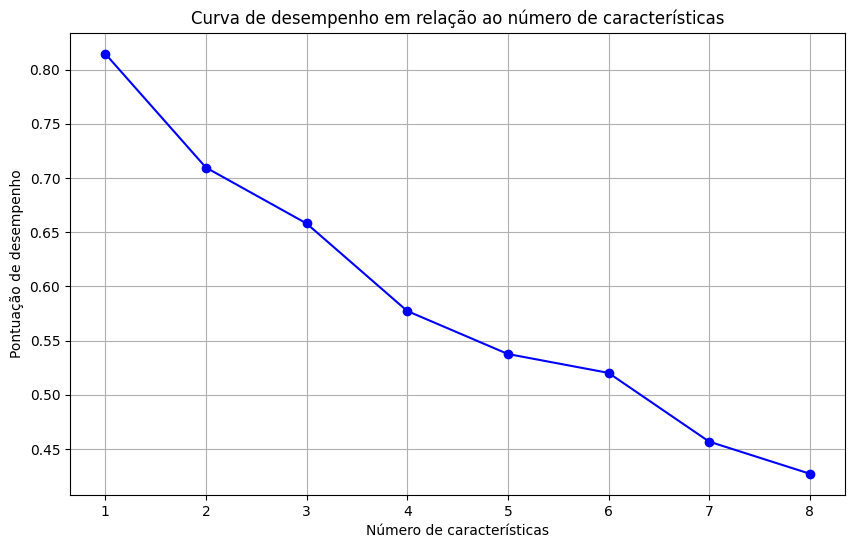

Number of selected features: 8


In [107]:
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
features_selected = cluster_feature_optimizer(kmeans, data, n_features)

# features_selected = ['P_EXTR',
# 'TXCOBPLP',
# 'REN_PIBPC_D',
# 'REN_PVAIND',
# 'PEA18M',
# 'PEA',
# 'PEA1517',
# 'P_TRANSF',
# 'RDPC4',
# 'REN5',
# 'PEA1014',
# 'EMP',
# 'T_SLUZ',
# 'SOBRE60',
# 'SOBRE40',
# 'MORT1',
# 'MORT5',
# 'IDHM_L',
# 'RDPC5',
# 'RDPC10']

print(f'Number of selected features: {len(features_selected)}')


In [108]:
data_array = data[features_selected].values

# Clusterização
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (Selected Features): {silhouette_score(data_array, clusters)}')

Silhouette Score (Selected Features): 0.43783366915115335


Inferência: O modelo clusterizado a partir das features selecionadas pelo método 2 apresentaram melhoria significativa no Silhouette Score, portanto, foi utilizado no agrupamento final.

> Criação do dataframe reduzido:

In [109]:
# Gera o dataframe com as features selecionadas
_columns = [
    "codigo_ibge",
    "nome",
    "codigo_uf",
    "UF",
    "latitude",
    "longitude",
    "POP_TOT",
]
_columns.extend(features_selected)

reduced_lowPop_df = lowPop_municipios_df[_columns]

reduced_lowPop_df['cluster'] = clusters.astype(str)
# Dataframe apenas com variáveis selecionadas pela otimização
reduced_lowPop_df

/tmp/ipykernel_41/821434987.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1255      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1256      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1257      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1258      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1259      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

        P_EXTR  REN_PVAIND    PEA18M  REN_PIBPC_D  TXCOBPLP  P_TRANSF  \
0    -0.319881   -0.453252 -0.253851    -0.692635 -0.154214 -0.422179   
1    -0.268103   -0.407851 -0.255242    -0.665722  2.055495 -0.688625   
2    -0.319881   -0.321588 -0.112445    -0.642174  0.174591 -0.506957   
3     2.568215    2.031351 -0.162863    -0.177938  0.086203  3.384182   
4    -0.319881    1.476317  0.678343     0.215653 -0.224924  0.057076   
...        ...         ...       ...          ...       ...       ...   
1255 -0.319881   -0.241000 -0.238490    -0.591714 -0.532516 -0.456783   
1256 -0.216324   -0.614428 -0.367425    -0.581622 -0.543122 -0.493116   
1257 -0.319881   -0.423741 -0.182934     0.198833 -0.437056 -0.525989   
1258 -0.181805   -0.462333  0.463720    -0.346140 -0.288564 -0.335671   
1259  0.709938   -0.500924 -0.385890    -0.251947 -0.338061  0.314871   

         RDPCT   RENOCUP cluster  
0    -0.652225 -0.187046       1  
1     0.249043 -0.686596       1  
2    -0.716793 -0.336365       1  
3    -0.223702  0.509527       0  
4    -0.294204  0.129609       1  
...        ...       ...     ...  
1255  0.125699 -0.068300       1  
1256 -1.138533 -1.125955       1  
1257  0.079216  0.366828       1  
1258 -0.081003  0.358024       1  
1259 -0.046105 -0.959233       1  

[1220 rows x 16 columns]

In [110]:
fig = px.scatter_mapbox(
    reduced_lowPop_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    # size='POP_TOT',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Inferência: Ficou ruim, logo não utilizamos

### Análise de correlação

Por se tratar de um longo conjunto de dados com variáveis diversas, foi preciso avaliar a existência de variáveis correlacionadas a fim de melhorar os posteriores procedimentos de otimização. Para isso, realizou-se um algoritmo que identifica exclui variáveis redundantes com base em uma tolerância positiva e negativa.

In [111]:
# Função para remoção de features correlacionadas a partir de uma tolerância
def remove_correlated(data, tolerance = 0.85):

    features = data.columns
    n_features = features.shape[0]
    correlation_matrix = data.corr().values
    correlated_features = []
    remove_features = []

    # Gera uma lista de variáveis correlacionadas 
    for row in range(n_features):
        for col in range(row, n_features):
            if(row == col):
                pass
            else:
                _val = correlation_matrix[row][col]
                if(_val >= tolerance or _val <= -tolerance):
                    correlated_features.append([features[row], features[col]])
                    # Apenas o primeiro feature do par é selecionado para remoção (pode ser alterado depois)
                    if(features[row] not in remove_features):
                        remove_features.append(features[row])

    # Remove features selecionadas
    for feature in remove_features:
        data.drop([feature], axis=1, inplace=True)

    print(f'Initial number of features: {n_features}')
    print(f'Final number of features: {data.shape[1]}')
    print('Features removed: \n', remove_features, '\n')

    return remove_features

# Plot de matrix de correlação
def plot_correlation(correlation_matrix):
    # Gera uma máscara com o triângulo superior
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.title("Matriz de Correlação entre Features em cada Cluster")

    plt.show()

Initial number of features: 8
Final number of features: 7
Features removed: 
 ['RDPCT'] 



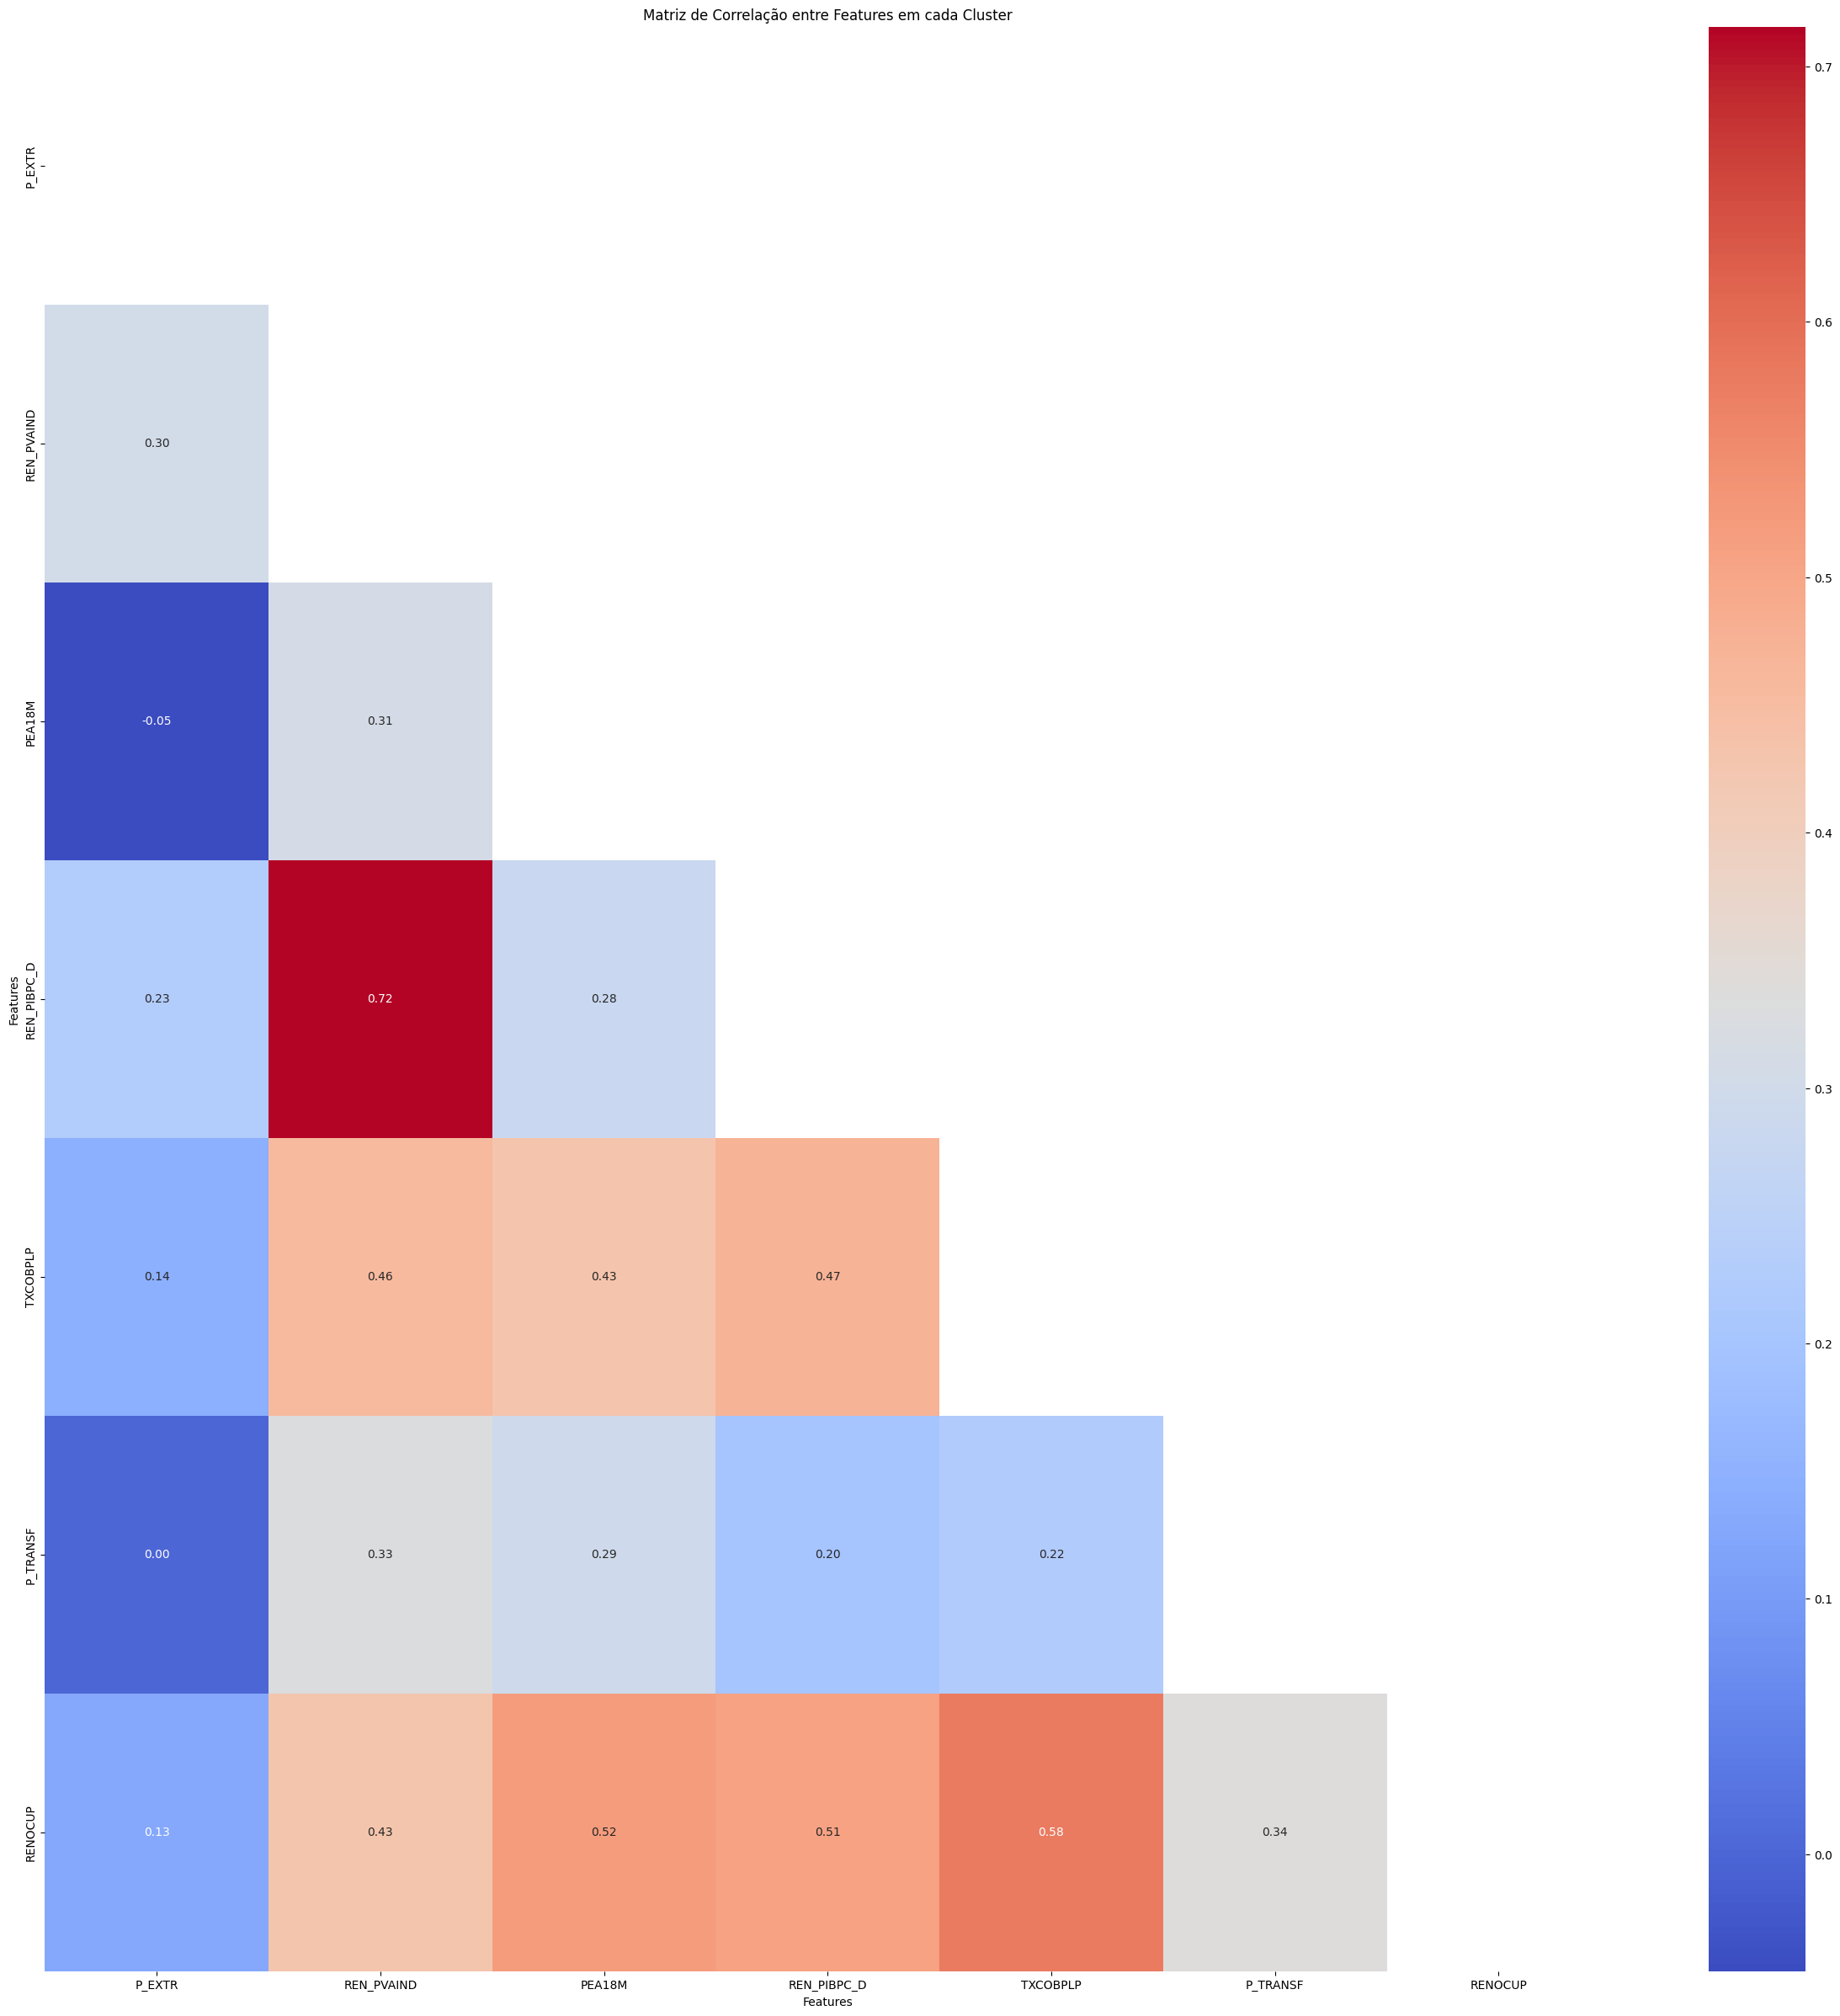

In [112]:
data = reduced_lowPop_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
).copy()

remove_features = remove_correlated(data, tolerance=0.8)

plot_correlation(data.corr())

In [113]:
# Remove as features redundantes
reduced2_lowPop_df = reduced_lowPop_df.copy()
for feature in remove_features:
    reduced2_lowPop_df.drop([feature], axis=1, inplace=True)
reduced2_lowPop_df

codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1255      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1256      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1257      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1258      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1259      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

        P_EXTR  REN_PVAIND    PEA18M  REN_PIBPC_D  TXCOBPLP  P_TRANSF  \
0    -0.319881   -0.453252 -0.253851    -0.692635 -0.154214 -0.422179   
1    -0.268103   -0.407851 -0.255242    -0.665722  2.055495 -0.688625   
2    -0.319881   -0.321588 -0.112445    -0.642174  0.174591 -0.506957   
3     2.568215    2.031351 -0.162863    -0.177938  0.086203  3.384182   
4    -0.319881    1.476317  0.678343     0.215653 -0.224924  0.057076   
...        ...         ...       ...          ...       ...       ...   
1255 -0.319881   -0.241000 -0.238490    -0.591714 -0.532516 -0.456783   
1256 -0.216324   -0.614428 -0.367425    -0.581622 -0.543122 -0.493116   
1257 -0.319881   -0.423741 -0.182934     0.198833 -0.437056 -0.525989   
1258 -0.181805   -0.462333  0.463720    -0.346140 -0.288564 -0.335671   
1259  0.709938   -0.500924 -0.385890    -0.251947 -0.338061  0.314871   

       RENOCUP cluster  
0    -0.187046       1  
1    -0.686596       1  
2    -0.336365       1  
3     0.509527       0  
4     0.129609       1  
...        ...     ...  
1255 -0.068300       1  
1256 -1.125955       1  
1257  0.366828       1  
1258  0.358024       1  
1259 -0.959233       1  

[1220 rows x 15 columns]

### Otimização de centroides

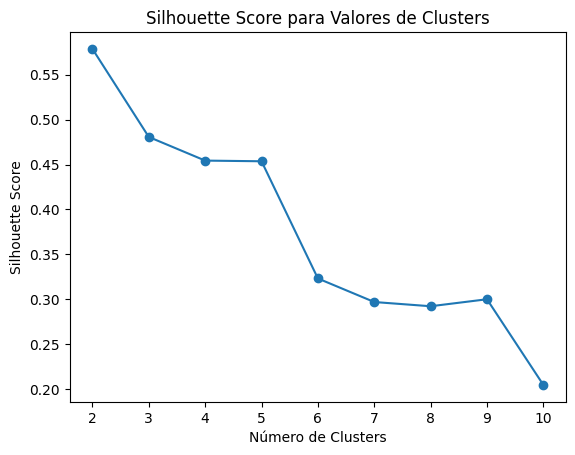

O melhor número de clusters é: 2


In [114]:
# Definer uma faixa de números de clusters para testar
min_clusters = 2
max_clusters = 10
range_n_clusters = range(min_clusters, max_clusters + 1)

# Lista para armazenar os valores do silhouette_score
silhouette_scores = []

# Executa o K-Means para diferentes números de clusters e calcula o silhouette_score
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plota o gráfico do silhouette_score para cada número de clusters
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score para Valores de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Encontre o número de clusters que maximiza o silhouette_score
best_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"O melhor número de clusters é: {best_n_clusters}")

### Clusterização

In [115]:
n_clusters = 5

In [116]:
# Clusterização por características
data = reduced2_lowPop_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
)

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data.values)
reduced2_lowPop_df['cluster'] = clusters.astype(str)

print(f'Silhouette Score: {silhouette_score(data.values, clusters)}')

Silhouette Score: 0.4448307108143869


In [117]:
fig = px.scatter_mapbox(
    reduced2_lowPop_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Análise de importância com classificador

Esta análise consistiu em coverter o problema de agrupamento não supervisionado em um problema de classificação supervisionado usando um classificador. As etapas são as seguintes:

- 1: Alterar os rótulos do cluster para rótulos binários Um-vs-Todos

- 2: Treinar um classificador (RandomForest e XGBoost) para diferenciar um cluster dos demais

- 3: Imprimir as importâncias de cada variável do modelo 

In [144]:
# Essa implementacao analisa a importancia dos features para diferenciação.
def features_importance(df_original, clusters, mapa_cluster):
    # mapa_cluster = {0:1, 1:0, 2:0, 3:0}
    df = df_original.copy()
    df["cluster"] = clusters

    print(df['cluster'].value_counts())
    df['cluster'] = df['cluster'].astype(int)
    binary_cluster = df['cluster'].map(mapa_cluster)

    # Treinar classificador
    df = df.drop(columns=['cluster'])
    clf = RandomForestClassifier(random_state=1)
    clf.fit(df.values, binary_cluster.values)

    # Index sort as variáveis mais importantes
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

    # Salvar os features mais importantes com os nomes e pesos
    most_important_features = np.take_along_axis(
        np.array(df.iloc[:, 0:len(df.columns)].columns.tolist()), 
        sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(
        np.array(clf.feature_importances_), 
        sorted_feature_weight_idxes, axis=0)

    return list(zip(most_important_features, most_important_weights))

# Mesmo método, porém utilizando o XGBoost
def features_importance_xgboost(df_original, n_clusters, clusters, cluster_to_map):
    mapa_cluster = {0:0, 1:0, 2:0, 3:0, 4:0}
    mapa_cluster[cluster_to_map] = 1

    df = df_original.copy()
    df['cluster'] = clusters
    binary_cluster = df['cluster'].map(mapa_cluster)
    df = df.drop(columns=['cluster'])

    # Treina o modelo xgboost
    clf = xgb.XGBRegressor(objective='multi:softmax', num_class=n_clusters)
    clf.fit(df.values, binary_cluster)
    # Necessário para que apareça os nomes das features
    clf.get_booster().feature_names = df.columns.to_list()
    print("Performance do modelo xgboost: ", str(round(clf.score(df.values, binary_cluster) * 100, 2))+"%")
    feature_importance = clf.get_booster().get_score(importance_type='weight')
    # xgb.plot_importance(clf)

    feature_importance_sorted = feature_importance
    # feature_importance_sorted = dict(sorted(feature_importance.items(), key=lambda item: item[1]))
    keys = list(feature_importance_sorted.keys())
    values = list(feature_importance_sorted.values())

    plot = sns.barplot(x=keys, y=values, width=1, palette='Paired')

    for item in plot.get_xticklabels():
        item.set_rotation(45)
    plt.title(f'Cluster {cluster_to_map}')
    plt.xlabel('Feature')
    plt.ylabel('XGBoost weight')
    plt.show()

    return feature_importance

Performance do modelo xgboost:  100.0%


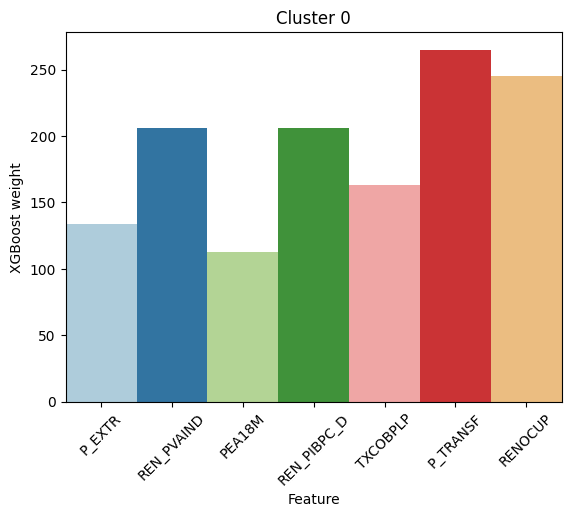

Performance do modelo xgboost:  100.0%


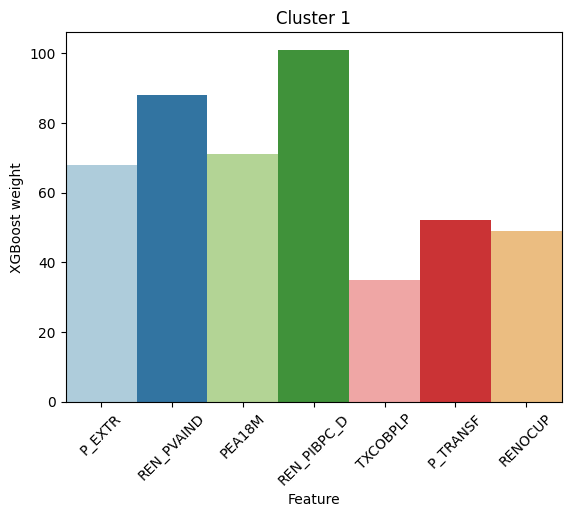

Performance do modelo xgboost:  100.0%


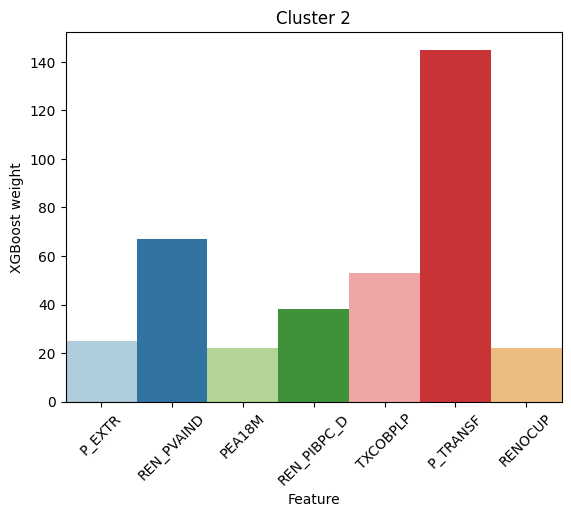

Performance do modelo xgboost:  100.0%


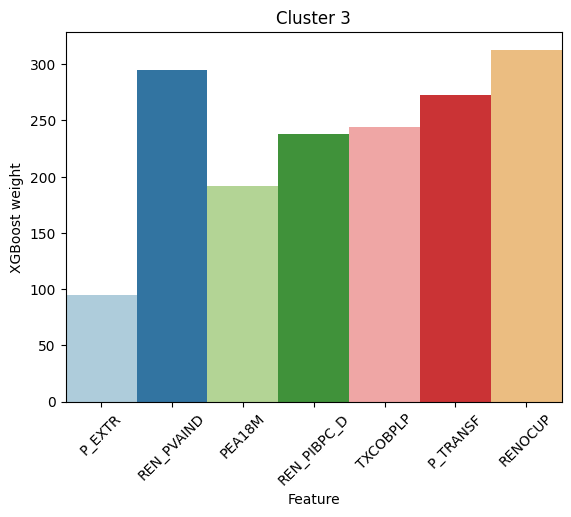

Performance do modelo xgboost:  100.0%


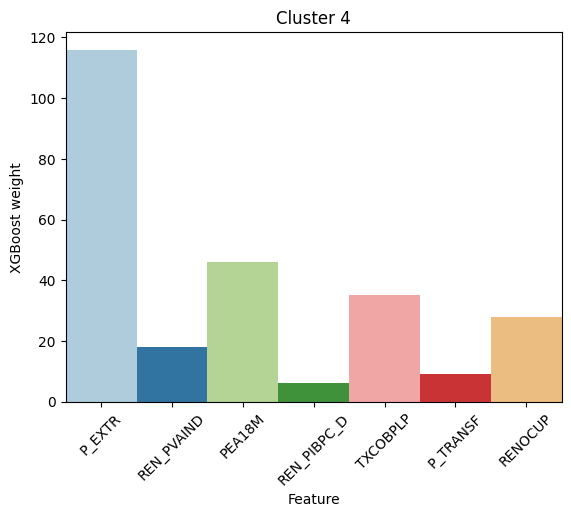

In [146]:
# important_features = features_importance(data, clusters)
# print(important_features, '\n')
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=0)
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=1)
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=2)
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=3)
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=4)

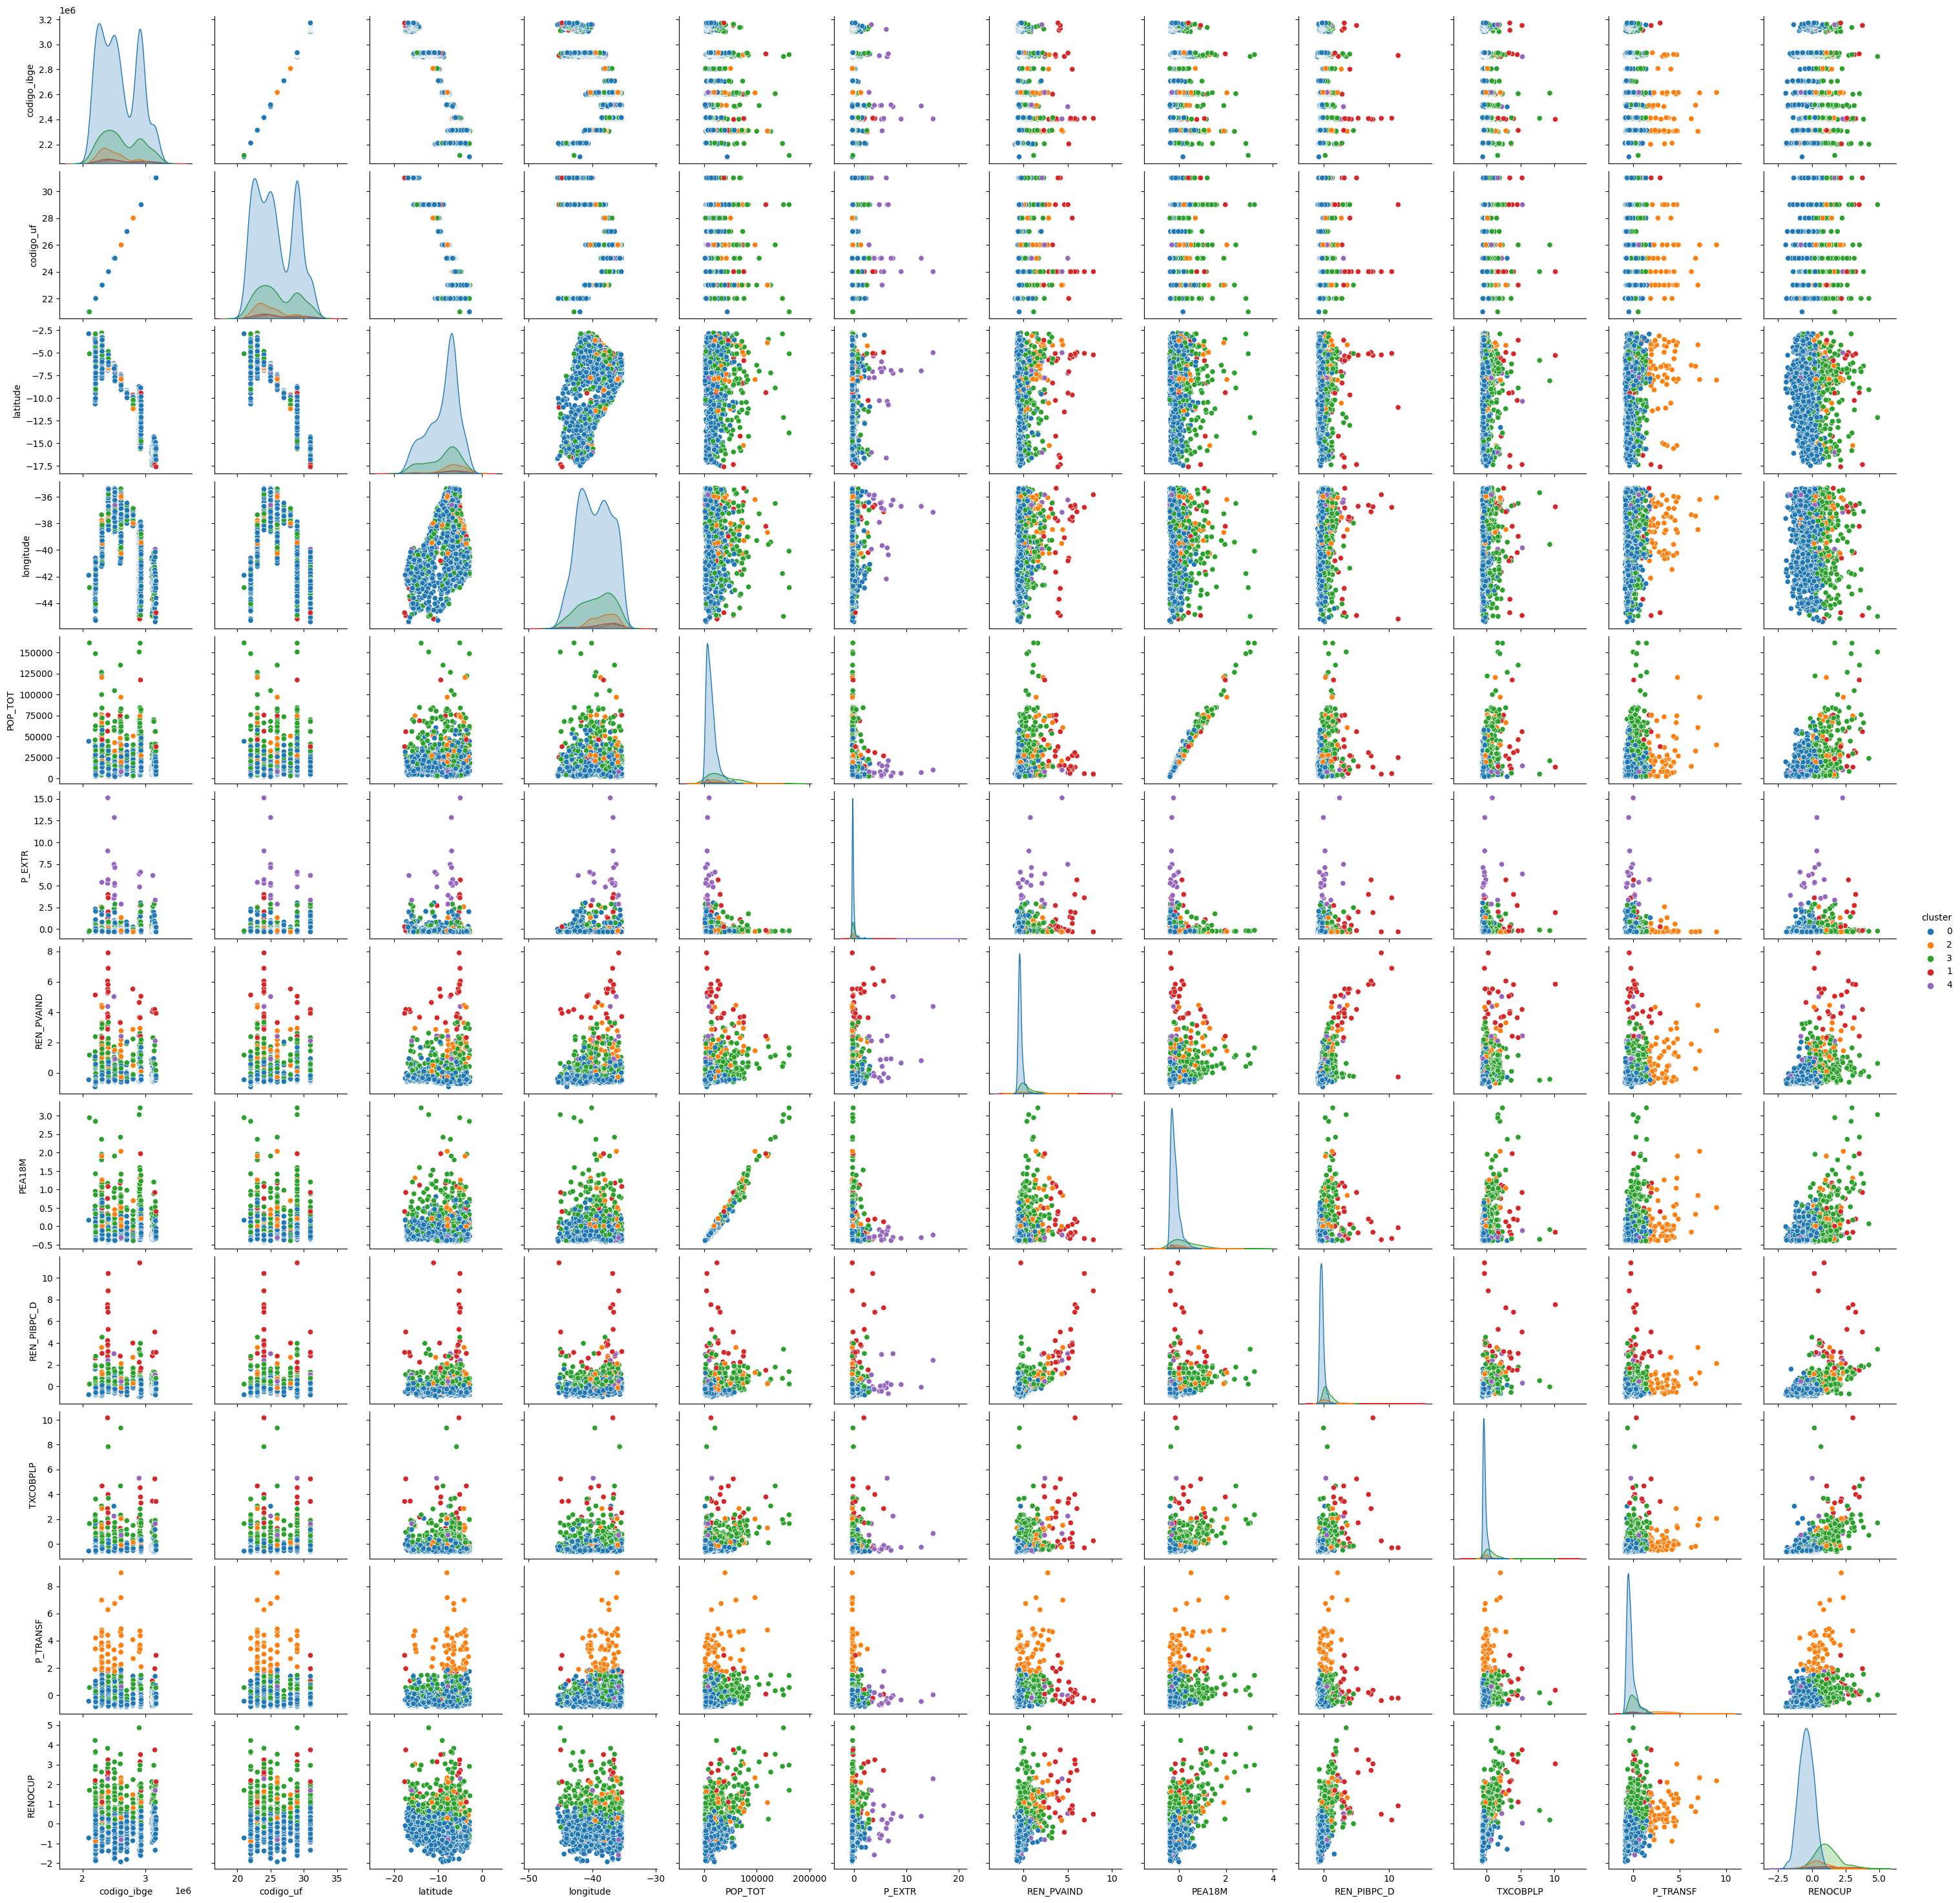

In [122]:
# Pairplot das variáveis 
sns.pairplot(data=reduced2_lowPop_df, hue='cluster')
plt.show()

Inferência: Os clusters foram separados em características bem definidas: C0: Municípios com baixa renda per capta, C1: Municípios com mais alta renda per capta dentre os outros, C2:  Municípios com mais alta renda e alta industrialização, C3: Municípios com mais alta renda e baixa industrialização, C4: Municipios com mais alta taxa de extrativismo mineral.

# Análise dos municípios

## Comparação com Cidades do Bem

In [274]:
# Revertendo o dataset normalizado para seus valores iniciais
_municipios = reduced2_lowPop_df['nome']
unnormalized_df = original_merged_df[original_merged_df['nome'].isin(_municipios)]
unnormalized_df['cluster'] = reduced2_lowPop_df['cluster'].astype(str)
unnormalized_df

/tmp/ipykernel_41/347483020.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3         2300150      ACARAPE  -4.22083   -38.7055         23  CE   
4         2300200       ACARAÚ  -2.88769   -40.1183         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                 2.4              5.9    17.24         5.23  ...   
1                 4.4             16.5    55.56         5.58  ...   
2                 3.5             11.5     6.90         3.74  ...   
3                 4.3             16.0    20.58         5.18  ...   
4                 3.1             10.3    17.56         5.12  ...   
...               ...              ...      ...          ...  ...   
1255              4.8              8.3     7.75         6.31  ...   
1256              2.2             18.5     0.00         4.36  ...   
1257              4.7              6.4    21.39         4.74  ...   
1258              6.1             11.7    17.07         5.24  ...   
1259              1.1             11.3     0.00         5.07  ...   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                     30.48            1.61         8.04    0.64  0.628   
1                     15.61            3.86         5.35    2.31  0.603   
2                     25.37            2.00         8.76    9.17  0.575   
3                     29.18            1.25         5.39    0.57  0.606   
4                     27.93            1.09         5.80    4.42  0.601   
...                     ...             ...          ...     ...    ...   
1255                  19.28            2.99         4.09    3.87  0.587   
1256                  27.82            0.17         6.97    3.21  0.544   
1257                  26.37            1.87         4.08   14.26  0.600   
1258                  18.49            3.18         6.14    4.86  0.585   
1259                  15.63            0.00         1.80    0.68  0.623   

      IDHM_E  IDHM_L  IDHM_R   PEA18M  cluster  
0      0.612   0.748   0.540   3481.0        0  
1      0.510   0.746   0.577   3455.0        0  
2      0.460   0.776   0.533   6123.0        0  
3      0.562   0.709   0.559   5181.0        2  
4      0.517   0.758   0.554  20898.0        3  
...      ...     ...     ...      ...      ...  
1255   0.479   0.737   0.573   3768.0        0  
1256   0.443   0.708   0.513   1359.0        0  
1257   0.498   0.764   0.569   4806.0        0  
1258   0.479   0.741   0.563  16888.0        0  
1259   0.587   0.725   0.567   1014.0        0  

[1220 rows x 67 columns]

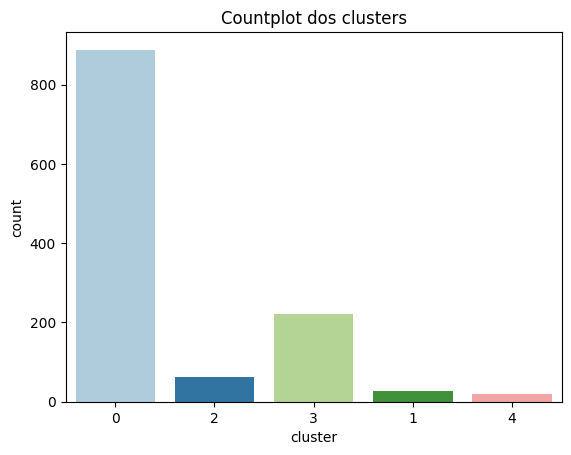

In [169]:
# Verifica a quantidade de municípios em cada cluster
sns.countplot(data=unnormalized_df, x='cluster', palette='Paired')
plt.title('Countplot dos clusters')
plt.show()

<img src="cidades do bem.png" width="75%" align="" />

<img src="cidades do bem 2.png" width="75%" align="" />

In [182]:
municipios_do_bem = [
                    'INAJÁ',
                    'BUÍQUE',
                    'SÃO JOSÉ DA TAPERA',
                    'MAURITI'
                    ]
                    
mask = unnormalized_df['nome'].isin(municipios_do_bem)
municipios_do_bem_df = unnormalized_df[mask]

municipios_do_bem_df[['nome', 'UF', 'cluster']]

nome  UF cluster
185               BUÍQUE  PE       0
486                INAJÁ  PE       0
695              MAURITI  CE       0
1067  SÃO JOSÉ DA TAPERA  AL       0

> Como todas as cidades do bem se localizam no cluster 0, podemos descartar os demais clusters para manter um número reduzido de municípios semelhantes:

In [276]:
# Filtra os municípios pertencentes aos mesmos clusters dos municípios do bem
clusters_do_bem = municipios_do_bem_df['cluster'].unique()
mask = unnormalized_df['cluster'].isin(clusters_do_bem)
unnormalized_df = unnormalized_df[mask]
unnormalized_df.drop(columns=['cluster'], inplace=True)
unnormalized_df

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
6         2200053        ACAUÃ  -8.21954   -41.0831         22  PI   
7         2300309     ACOPIARA  -6.08911   -39.4480         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  RENOCUP  \
0                 2.4              5.9    17.24         5.23  ...   410.96   
1                 4.4             16.5    55.56         5.58  ...   337.76   
2                 3.5             11.5     6.90         3.74  ...   389.08   
6                 5.2             14.6    25.00         5.37  ...   225.42   
7                 3.2             13.7    17.30         6.68  ...   398.32   
...               ...              ...      ...          ...  ...      ...   
1255              4.8              8.3     7.75         6.31  ...   428.36   
1256              2.2             18.5     0.00         4.36  ...   273.38   
1257              4.7              6.4    21.39         4.74  ...   492.12   
1258              6.1             11.7    17.07         5.24  ...   490.83   
1259              1.1             11.3     0.00         5.07  ...   297.81   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                     30.48            1.61         8.04    0.64  0.628   
1                     15.61            3.86         5.35    2.31  0.603   
2                     25.37            2.00         8.76    9.17  0.575   
6                     20.77            0.50         3.92    1.01  0.528   
7                     24.61            1.05         7.28    1.60  0.595   
...                     ...             ...          ...     ...    ...   
1255                  19.28            2.99         4.09    3.87  0.587   
1256                  27.82            0.17         6.97    3.21  0.544   
1257                  26.37            1.87         4.08   14.26  0.600   
1258                  18.49            3.18         6.14    4.86  0.585   
1259                  15.63            0.00         1.80    0.68  0.623   

      IDHM_E  IDHM_L  IDHM_R   PEA18M  
0      0.612   0.748   0.540   3481.0  
1      0.510   0.746   0.577   3455.0  
2      0.460   0.776   0.533   6123.0  
6      0.411   0.692   0.517   2815.0  
7      0.517   0.724   0.563  19055.0  
...      ...     ...     ...      ...  
1255   0.479   0.737   0.573   3768.0  
1256   0.443   0.708   0.513   1359.0  
1257   0.498   0.764   0.569   4806.0  
1258   0.479   0.741   0.563  16888.0  
1259   0.587   0.725   0.567   1014.0  

[888 rows x 66 columns]

## Análise de viabilidade

### Custos de transporte

In [363]:
# Carregando o dataset de transporte
original_transportes_df = pd.read_csv('./Data/transport_cost.csv')
transportes_df = original_transportes_df.copy()
transportes_df.drop(columns=['codigo_ibge', 'codigo_uf'], inplace=True)
transportes_df

mask = transportes_df['nome'].isin(unnormalized_df['nome'].values)
unique_cities = transportes_df[mask]['nome'].unique()

# mean_transportation_cost = []
# for city in unique_cities:
#     _df = transportes_df[transportes_df['codigo_ibge'] == city]
#     mean_transportation_cost.append(_df['transportation_cost'].values.mean())

# unnormalized_transport_df = unnormalized_df.copy()
# unnormalized_transport_df['transportation_cost'] = mean_transportation_cost
# unnormalized_transport_df
unique_cities


array([], dtype=object)

In [284]:
unnormalized_transportes_df = pd.merge(unnormalized_df, transportes_df, left_on='codigo_ibge', right_on='codigo_ibge')
unnormalized_transportes_df

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
6         2200053        ACAUÃ  -8.21954   -41.0831         22  PI   
7         2300309     ACOPIARA  -6.08911   -39.4480         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  RENOCUP  \
0                 2.4              5.9    17.24         5.23  ...   410.96   
1                 4.4             16.5    55.56         5.58  ...   337.76   
2                 3.5             11.5     6.90         3.74  ...   389.08   
6                 5.2             14.6    25.00         5.37  ...   225.42   
7                 3.2             13.7    17.30         6.68  ...   398.32   
...               ...              ...      ...          ...  ...      ...   
1255              4.8              8.3     7.75         6.31  ...   428.36   
1256              2.2             18.5     0.00         4.36  ...   273.38   
1257              4.7              6.4    21.39         4.74  ...   492.12   
1258              6.1             11.7    17.07         5.24  ...   490.83   
1259              1.1             11.3     0.00         5.07  ...   297.81   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                     30.48            1.61         8.04    0.64  0.628   
1                     15.61            3.86         5.35    2.31  0.603   
2                     25.37            2.00         8.76    9.17  0.575   
6                     20.77            0.50         3.92    1.01  0.528   
7                     24.61            1.05         7.28    1.60  0.595   
...                     ...             ...          ...     ...    ...   
1255                  19.28            2.99         4.09    3.87  0.587   
1256                  27.82            0.17         6.97    3.21  0.544   
1257                  26.37            1.87         4.08   14.26  0.600   
1258                  18.49            3.18         6.14    4.86  0.585   
1259                  15.63            0.00         1.80    0.68  0.623   

      IDHM_E  IDHM_L  IDHM_R   PEA18M  
0      0.612   0.748   0.540   3481.0  
1      0.510   0.746   0.577   3455.0  
2      0.460   0.776   0.533   6123.0  
6      0.411   0.692   0.517   2815.0  
7      0.517   0.724   0.563  19055.0  
...      ...     ...     ...      ...  
1255   0.479   0.737   0.573   3768.0  
1256   0.443   0.708   0.513   1359.0  
1257   0.498   0.764   0.569   4806.0  
1258   0.479   0.741   0.563  16888.0  
1259   0.587   0.725   0.567   1014.0  

[888 rows x 66 columns]

### Povoados próximos

In [ ]:

path = "/work/BR_Localidades_2010_v1.dbf"

df_povoado = Dbf5(path)#.to_dataframe()

df_povoado = Dbf5(path, codec="latin-1").to_dataframe()

df_povoado

## Análise por renda mínima

### Linha de miséria

In [134]:
# Dataset de dados do censo
censo_df1 = pd.read_csv('./Data/censo.csv',delimiter=';')
mask = ["ANO", 
        "Codmun7", 
        "MORT1", "MORT5", 
        "SOBRE40", "SOBRE60", "E_ANOSESTUDO", 
        "T_ANALF11A14", "T_ANALF15A17", "T_ANALF15M", "T_ANALF18A24", "T_ANALF18M", "T_ANALF25A29", "T_ANALF25M", 
        "GINI", "PIND", "PINDCRI", "PMPOB", "PMPOBCRI", "PPOB", "PPOBCRI", 
        "PREN10RICOS", "PREN20", "PREN20RICOS", "PREN40", "PREN60", "PREN80", 
        "RDPC", "RDPCT", "RIND", "RMPOB", "RPOB", #"RDPC1", "RDPC10", "RDPC2", "RDPC3", "RDPC4", "RDPC5", 
        "THEIL", "CPR", "EMP", "P_AGRO", "P_COM", "P_CONSTR", "P_TRANSF", "P_EXTR",
        "REN0", "REN1", "RENOCUP", #"REN2", "REN3", "REN5",  
        "T_NESTUDA_NTRAB_MMEIO", "T_OCUPDESLOC_1", "T_RMAXIDOSO", "T_SLUZ", 
        "IDHM", "IDHM_E", "IDHM_L", "IDHM_R", "PEA18M",] #"PEA", "PEA1014", "PEA1517",  ]
# NÃO APAGAR "HOMEM0A4", "HOMEM10A14", "HOMEM15A19", "HOMEM20A24", "HOMEM25A29", "HOMEM30A34", "HOMEM35A39", "HOMEM40A44", "HOMEM45A49", "HOMEM50A54", "HOMEM55A59", "HOMEM5A9", "HOMEM60A64", "HOMEM65A69", "HOMEM70A74", "HOMEM75A79", "HOMEMTOT", "HOMENS80", "MULH0A4", "MULH10A14", "MULH15A19", "MULH20A24", "MULH25A29", "MULH30A34", "MULH35A39", "MULH40A44", "MULH45A49", "MULH50A54", "MULH55A59", "MULH5A9", "MULH60A64", "MULH65A69", "MULH70A74", "MULH75A79", "MULHER80", "MULHERTOT",
censo_df1 = censo_df1[mask]
censo_df1 = censo_df1[censo_df1["ANO"] == 2010]
censo_df1

ANO  Codmun7  MORT1  MORT5  SOBRE40  SOBRE60  E_ANOSESTUDO  \
11130  2010  1100015  23.80  25.49    94.50    83.18          8.67   
11131  2010  1100023  19.20  20.53    96.12    87.69          9.18   
11132  2010  1100031  24.80  26.58    94.27    82.57         10.09   
11133  2010  1100049  14.30  15.38    96.41    88.56          9.74   
11134  2010  1100056  18.10  19.42    95.78    86.72         10.22   
...     ...      ...    ...    ...      ...      ...           ...   
16690  2010  5222005  14.40  17.04    93.03    82.02         10.11   
16691  2010  5222054  15.70  18.51    92.47    80.75         10.07   
16692  2010  5222203  14.50  17.09    93.02    81.98         10.49   
16693  2010  5222302  15.90  18.80    92.36    80.50          9.46   
16694  2010  5300108  14.01  15.85    94.57    86.19          9.87   

       T_ANALF11A14  T_ANALF15A17  T_ANALF15M  ...  RENOCUP  \
11130          1.22          1.52       11.99  ...   950.08   
11131          1.55          1.09        7.90  ...  1274.11   
11132          0.62          1.06       13.63  ...   827.86   
11133          1.01          0.80        8.29  ...  1277.37   
11134          1.14          0.75       10.29  ...   926.57   
...             ...           ...         ...  ...      ...   
16690          0.66          0.74        7.97  ...  1110.12   
16691          1.22          1.32       12.68  ...  1114.20   
16692          3.60          1.56       15.88  ...   792.05   
16693          4.15          1.99       19.25  ...   666.51   
16694          1.10          0.80        3.47  ...  2581.69   

       T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
11130                  16.12            1.15         2.20    6.02  0.641   
11131                   9.67            0.16         1.40    1.42  0.702   
11132                  16.59            0.65         3.10    3.64  0.650   
11133                   9.64            0.43         1.84    1.11  0.718   
11134                  10.16            0.38         1.43    1.15  0.692   
...                      ...             ...          ...     ...    ...   
16690                   5.63            1.23         1.33    0.17  0.712   
16691                  10.47            1.55         1.25    0.30  0.684   
16692                  21.64            1.74         3.81    0.22  0.647   
16693                  11.92            0.20         4.48    2.41  0.634   
16694                   5.13            1.40         0.71    0.09  0.824   

       IDHM_E  IDHM_L  IDHM_R     PEA18M  
11130   0.526   0.763   0.657     9928.0  
11131   0.600   0.806   0.716    42801.0  
11132   0.559   0.757   0.650     2648.0  
11133   0.620   0.821   0.727    37317.0  
11134   0.602   0.799   0.688     8133.0  
...       ...     ...     ...        ...  
16690   0.622   0.818   0.710     6201.0  
16691   0.562   0.804   0.707     3663.0  
16692   0.534   0.818   0.619     1962.0  
16693   0.505   0.802   0.629     2076.0  
16694   0.742   0.873   0.863  1361053.0  

[5565 rows x 52 columns]

In [188]:
df_pob = unnormalized_df.copy()

In [339]:
mask__1 = censo_df1[censo_df1["RDPC"]<188]["Codmun7"]
mask__2 = df_pob["codigo_ibge"].isin(mask__1)

df_pob = df_pob[mask__2]
df_pob["bem"] = "nao" 

renda_minima_df = pd.concat([municipios_do_bem_df,df_pob])
renda_minima_df

codigo_ibge                nome  latitude  longitude  codigo_uf  UF  \
185       2602803              BUÍQUE  -8.61954   -37.1606         26  PE   
486       2607000               INAJÁ  -8.90206   -37.8351         26  PE   
695       2308104             MAURITI  -7.38597   -38.7708         23  CE   
1067      2708402  SÃO JOSÉ DA TAPERA  -9.55768   -37.3831         27  AL   
43        2901155     AMÉRICA DOURADA -11.44290   -41.4390         29  BA   
...           ...                 ...       ...        ...        ...  ..   
1208      2615805         TUPANATINGA  -8.74798   -37.3445         26  PE   
1218      2932457           UMBURANAS -10.73390   -41.3234         29  BA   
1224      2313906              URUOCA  -3.30819   -40.5628         23  CE   
1240      2414753           VENHA-VER  -6.32016   -38.4896         24  RN   
1243      2211506         VERA MENDES  -7.59748   -41.4673         22  PI   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
185               5.0             10.7     9.39         5.41  ...   
486               5.6              8.0    42.61         3.90  ...   
695               2.6             10.0    17.70         5.13  ...   
1067              5.8             15.2    21.89         5.49  ...   
43                5.4              9.8     0.00         4.50  ...   
...               ...              ...      ...          ...  ...   
1208              4.6              5.1    24.84         4.29  ...   
1218              4.2             13.8    13.89         2.47  ...   
1224              3.0              8.6     0.00         5.09  ...   
1240              4.6             21.8     0.00         4.94  ...   
1243             12.3             25.0     0.00         9.27  ...   

      T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  IDHM_E  IDHM_L  IDHM_R  \
185             3.11         7.88    2.53  0.527   0.395   0.746   0.497   
486             2.31         4.39    1.95  0.523   0.400   0.711   0.503   
695             1.98         4.44    1.01  0.605   0.526   0.772   0.544   
1067            3.24         4.81    1.94  0.527   0.409   0.703   0.508   
43              5.62         5.41    2.86  0.561   0.464   0.751   0.506   
...              ...          ...     ...    ...     ...     ...     ...   
1208            6.09         4.88    1.64  0.519   0.379   0.747   0.494   
1218            4.21         7.99    6.27  0.515   0.413   0.705   0.469   
1224            1.03         7.12    2.69  0.566   0.485   0.745   0.503   
1240            1.96         7.15    1.26  0.555   0.473   0.722   0.501   
1243            1.37        12.34    0.73  0.503   0.375   0.685   0.494   

       PEA18M  cluster  bem  
185   15941.0        0  sim  
486    6114.0        0  sim  
695   15634.0        0  sim  
1067  10110.0        0  sim  
43     5721.0        0  nao  
...       ...      ...  ...  
1208   8240.0        0  nao  
1218   5575.0        0  nao  
1224   4181.0        0  nao  
1240   1369.0        0  nao  
1243   1201.0        0  nao  

[76 rows x 68 columns]

In [340]:
fig = px.scatter_mapbox(
    renda_minima_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='bem',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-terrain',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

## Atlas irrigação

O cultivo do cajueiro é realizado com sucesso quando as chuvas anuais situam-se nos limites entre 800mm a 1500mm, distribuídas em cinco a sete meses e período seco de cinco a seis meses, coincidindo com as fases de floração e frutificação. Contudo, cultivos bem sucedidos têm sido observados em regiões onde as chuvas alcançam 4000mm e estação seca de quatro a sete meses, nem sempre bem distribuída. Em regiões com chuvas inferiores a 600mm, o cajueiro tem respondido muito bem à irrigação.

Fonte: https://www.embrapa.br/agencia-de-informacao-tecnologica/cultivos/caju

In [313]:
atlas = pd.read_csv('/work/Data/Atlas Irrigacao - Area Atual e Potencial.csv', sep=';')

atlas

Código              Município  UF  Arroz Inundado     Café  \
0     1100015  Alta Floresta D'Oeste  RO             0.0    5.382   
1     1100023              Ariquemes  RO             0.0   31.000   
2     1100031                 Cabixi  RO             0.0   25.000   
3     1100049                 Cacoal  RO             0.0    6.818   
4     1100056             Cerejeiras  RO             0.0   20.000   
...       ...                    ...  ..             ...      ...   
5565  5222005             Vianópolis  GO             0.0    0.000   
5566  5222054         Vicentinópolis  GO             0.0    0.000   
5567  5222203               Vila Boa  GO             0.0    0.000   
5568  5222302          Vila Propício  GO             0.0    0.000   
5569  5300108               Brasília  DF             0.0  293.000   

      Cana-de-Açúcar Irrigada  \
0                       0.000   
1                       0.000   
2                       0.000   
3                       0.000   
4                       0.000   
...                       ...   
5565                    0.000   
5566                    2.127   
5567                    3.333   
5568                   16.537   
5569                    0.000   

      Outras Culturas em Pivôs Centrais (exceto arroz, café e cana)  \
0                                                 0.000               
1                                                 0.000               
2                                               533.000               
3                                                 0.000               
4                                                 0.000               
...                                                 ...               
5565                                              2.527               
5566                                              2.863               
5567                                              0.000               
5568                                            247.000               
5569                                             14.843               

      Pivôs Centrais - Total (considerando sobreposição com arroz, café e cana)  \
0                                                 0.000                           
1                                                 0.000                           
2                                               533.000                           
3                                                 0.000                           
4                                                 0.000                           
...                                                 ...                           
5565                                              2.527                           
5566                                              3.676                           
5567                                            586.000                           
5568                                            684.000                           
5569                                             14.981                           

      Outras culturas e sistemas  Área Total Irrigada  \
0                          3.203                8.585   
1                        148.000              179.000   
2                          0.000              558.000   
3                          3.934               10.752   
4                        892.000              912.000   
...                          ...                  ...   
5565                      98.000                2.625   
5566                       0.000                4.990   
5567                       9.000                3.342   
5568                       0.000               16.784   
5569                      18.222               33.358   

      Cana-de-Açúcar Fertirrigada  Área Total (Irrigada e Fertirrigada)  \
0                            0.00                                 8.585   
1                            0.00                               179.000   
2                    

In [314]:
municipios = unnormalized_reduced_df[unnormalized_reduced_df['cluster'] == 0]

codigos_ibge = municipios.codigo_ibge

Verificar municipios de producao de caju como é o potencial hidrico deles.

In [331]:
# Pegar apenas linhas com os mesmos codigos municipais que temos nos datasets anteriores
mask = atlas['Código'].isin(codigos_ibge)
atlas_filtrado = atlas[mask] 

atlas_filtrado

Código                   Município  UF  Arroz Inundado  Café  \
465   2100907                    Araioses  MA             0.0   0.0   
667   2200053                       Acauã  PI             0.0   0.0   
670   2200251          Alagoinha do Piauí  PI             0.0   0.0   
672   2200301                  Alto Longá  PI             0.0   0.0   
674   2200459        Alvorada do Gurguéia  PI             0.0   0.0   
...       ...                         ...  ..             ...   ...   
3030  3166956       Serranópolis de Minas  MG             0.0   6.0   
3076  3170651  Vargem Grande do Rio Pardo  MG             0.0   0.0   
3080  3170909                 Varzelândia  MG             0.0   0.0   
3082  3171030                 Verdelândia  MG             0.0   0.0   
3090  3171600              Virgem da Lapa  MG             0.0   0.0   

      Cana-de-Açúcar Irrigada  \
465                       0.0   
667                       0.0   
670                       0.0   
672                       0.0   
674                       0.0   
...                       ...   
3030                      0.0   
3076                      0.0   
3080                      0.0   
3082                      0.0   
3090                      0.0   

      Outras Culturas em Pivôs Centrais (exceto arroz, café e cana)  \
465                                               0.000               
667                                               0.000               
670                                               0.000               
672                                               0.000               
674                                             149.000               
...                                                 ...               
3030                                              0.000               
3076                                             91.000               
3080                                              0.000               
3082                                              1.279               
3090                                              0.000               

      Pivôs Centrais - Total (considerando sobreposição com arroz, café e cana)  \
465                                               0.000                           
667                                               0.000                           
670                                               0.000                           
672                                               0.000                           
674                                             149.000                           
...                                                 ...                           
3030                                              0.000                           
3076                                             91.000                           
3080                                              0.000                           
3082                                              1.279                           
3090                                              0.000                           

      Outras culturas e sistemas  Área Total Irrigada  \
465                       56.000               56.000   
667                       96.000               96.000   
670                        0.000                0.000   
672                      189.000              189.000   
674                      310.000              459.000   
...                          ...                  ...   
3030                     193.000              199.000   
3076                     262.000              353.000   
3080                     197.000              197.000   
3082                       3.543                4.823   
3090                     226.000              226.000   

      Cana-de-Açúcar Fertirrigada  Área Total (Irrigada e Fertirrigada)  \
465                           0.0                                56.000   
667                           0.0                                96.000 

In [ ]:
atlas_filtrado['AAI - Potencial Total']

array([[<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >]], dtype=object)

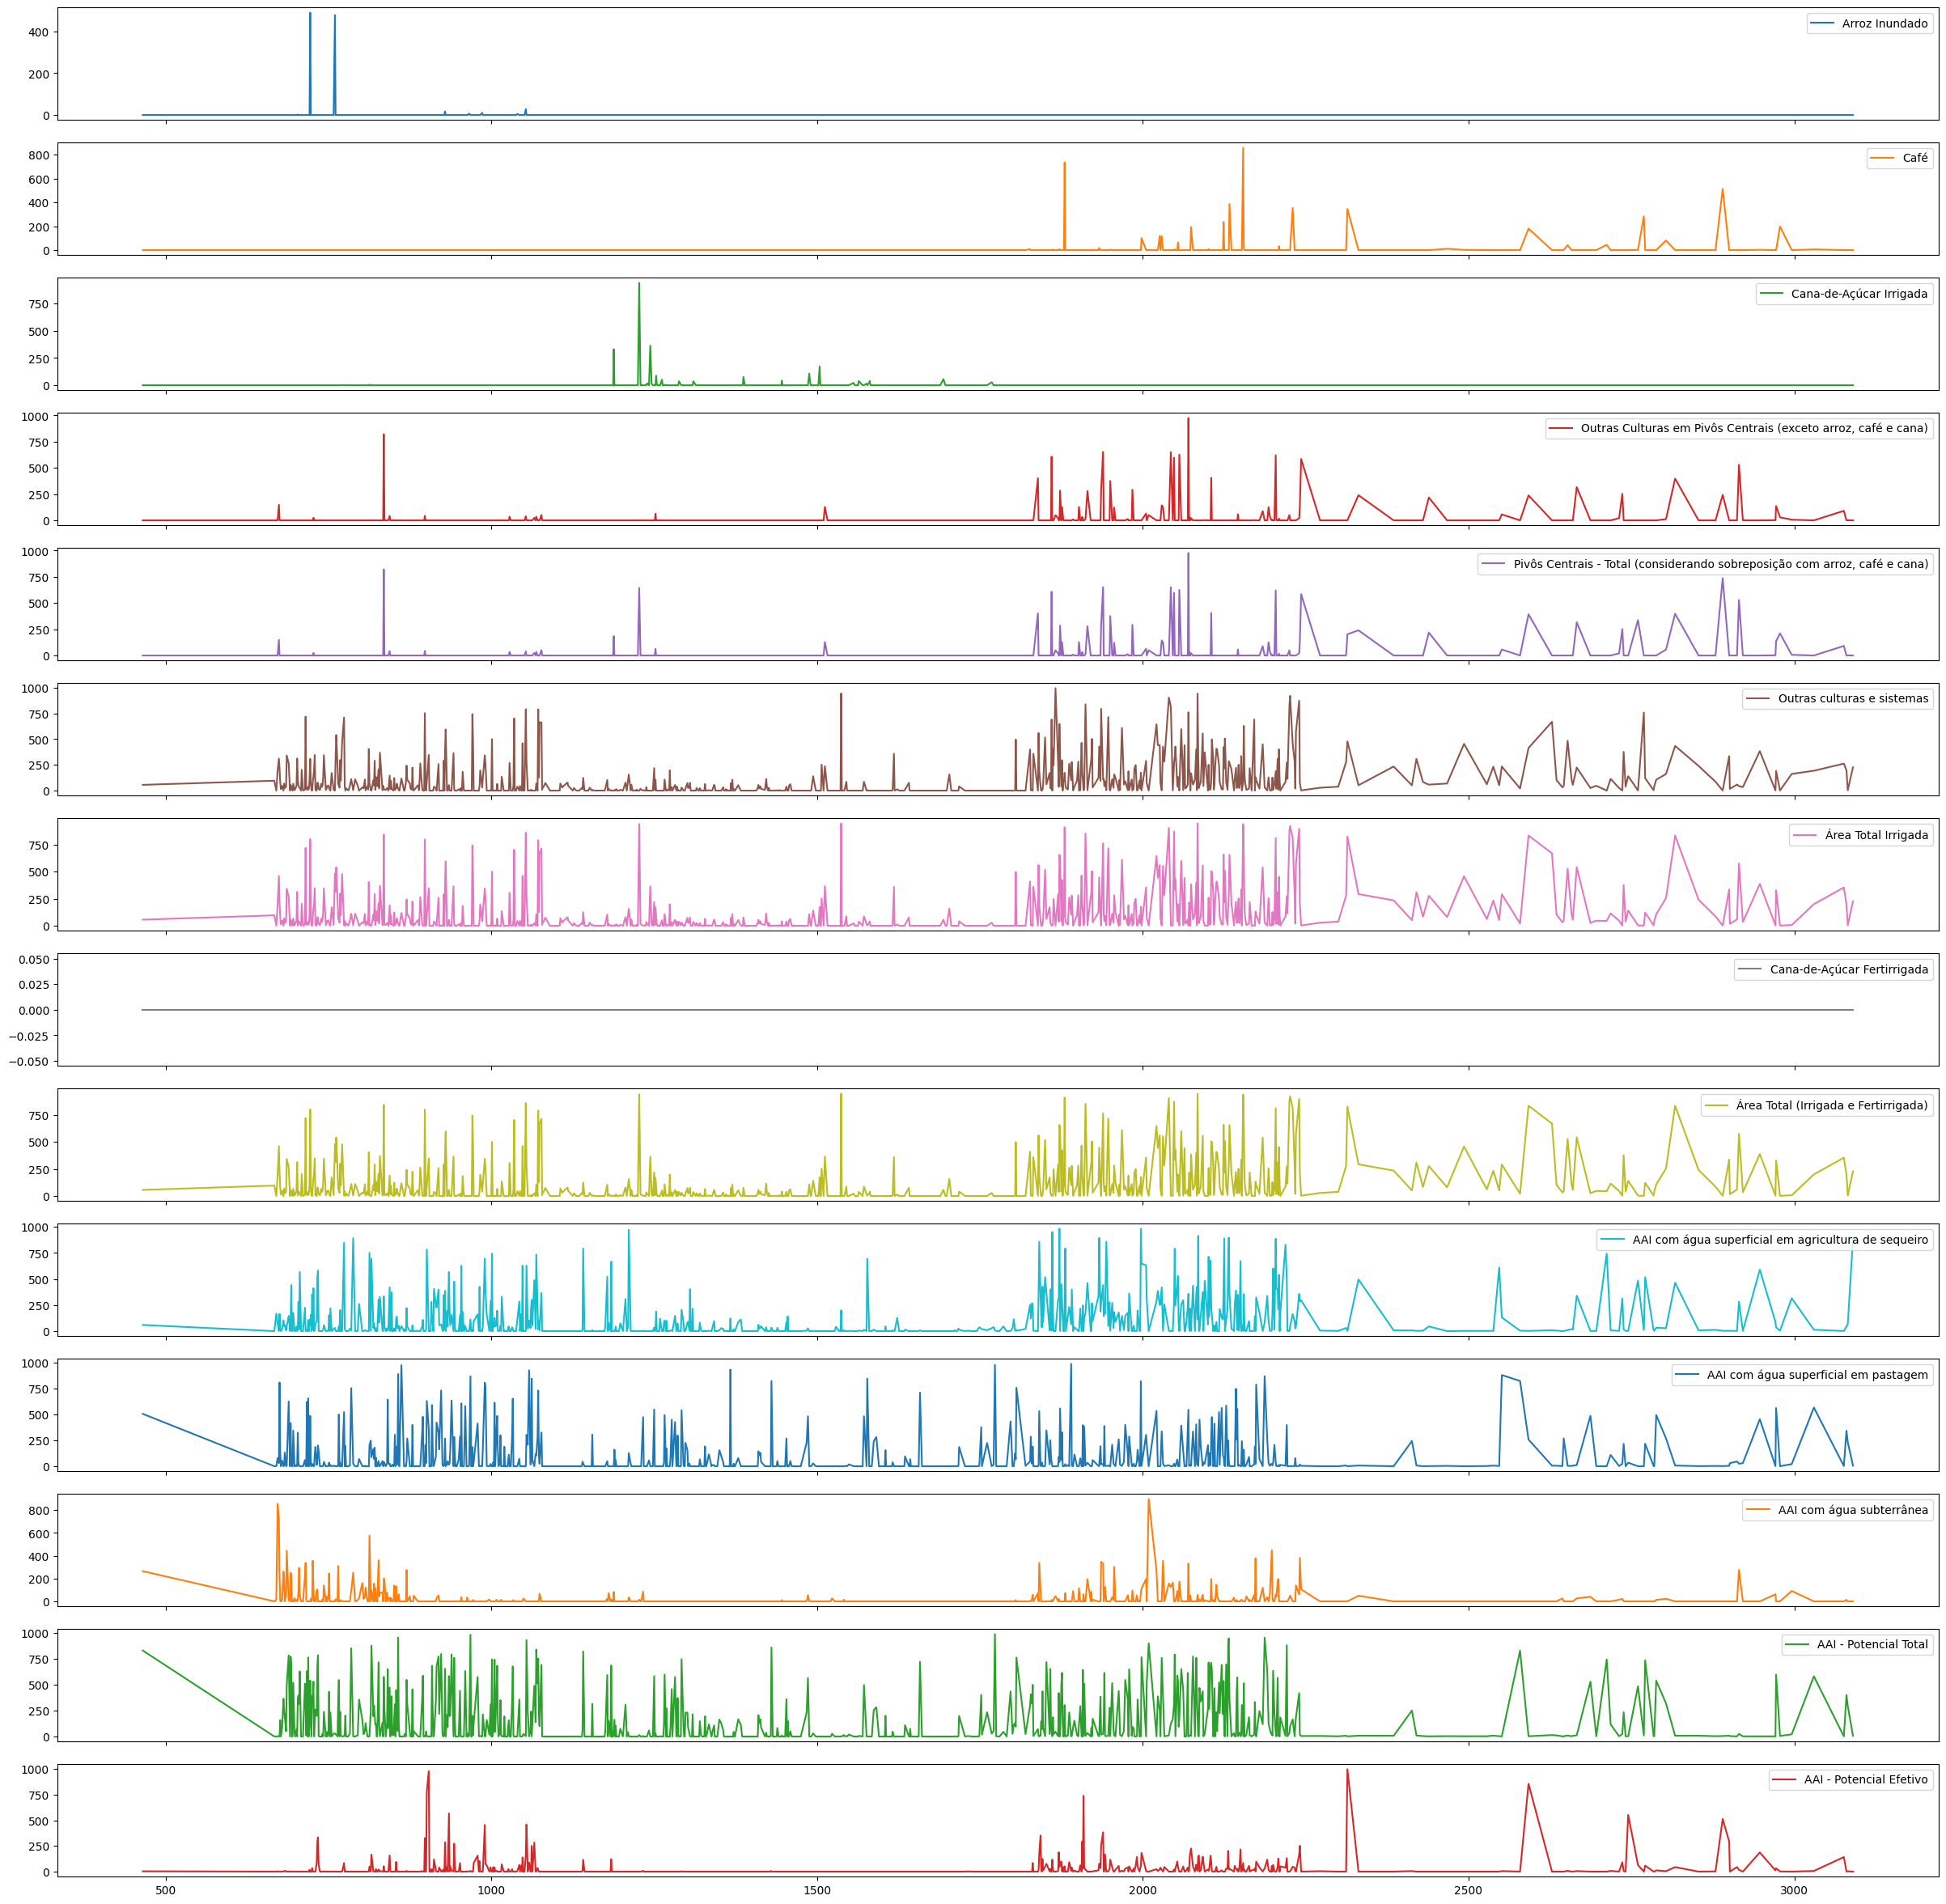

In [337]:
atlas_filtrado.drop(columns=['Código']).plot(subplots=True, layout=(14, 1), figsize=(30, 30))

## QEdu

In [317]:
QEdu_2019 = pd.read_csv("./Data/QEdu_2019.csv", sep = ';')

QEdu_2019

COD Municipio  \
0                                               2100477   
1                                               2611804   
2                                               2914000   
3                                               2905800   
4                                               2101707   
...                                                 ...   
1790                                            2200400   
1791                                            2604007   
1792                                            2931905   
1793                                            2930204   
1794  Contagem de escolas conforme rede e escolas co...   

                      Cidade  COD UF   UF Total de escolas federais  \
0     Alto Alegre do Pindaré    21.0   MA                       NaN   
1                   Ribeirão    26.0   PE                       NaN   
2                      Ipirá    29.0   BA                       NaN   
3                     Camamu    29.0   BA                       NaN   
4               Barreirinhas    21.0   MA                       1,0   
...                      ...     ...  ...                       ...   
1790                   Altos    22.0   PI                       NaN   
1791                 Carpina    26.0   PE                       NaN   
1792                  Tucano    29.0   BA                       NaN   
1793                Sento Sé    29.0   BA                       NaN   
1794                     NaN     NaN  NaN                       NaN   

     Total de escolas estaduais Total de escolas municipais  \
0                           8,0                        55,0   
1                           3,0                        32,0   
2                           4,0                        56,0   
3                           1,0                        81,0   
4                           5,0                       140,0   
...                         ...                         ...   
1790                        8,0                        54,0   
1791                        9,0                        22,0   
1792                        4,0                        56,0   
1793                        2,0                        62,0   
1794                        NaN                         NaN   

     Total de escolas privadas  Total de escolas sem creche  \
0                          1,0                         20.0   
1                         16,0                         10.0   
2                          9,0                         55.0   
3                          4,0                         61.0   
4                          5,0                        148.0   
...                        ...                          ...   
1790                       5,0                         49.0   
1791                      36,0                         23.0   
1792                       7,0                         20.0   
1793                       3,0                         61.0   
1794                       NaN                          NaN   

     Total de escolas com creche  ...  \
0                           44,0  ...   
1                           41,0  ...   
2                           14,0  ...   
3                           25,0  ...   
4                            3,0  ...   
...                          ...  ...   
1790                        18,0  ...   
1791                        44,0  ...   
1792                        47,0  ...   
1793                         6,0  ...   
1794                         NaN  ...   

     Total de docentes em Ensino Fundamental - Projovem Urbano  \
0                                                   NaN          
1                                                   NaN          
2                                                   NaN          
3                                                   NaN          
4                                                   NaN          
...                                                 ...          
1790       

In [318]:
QEdu_2019.columns

Index(['COD Municipio', 'Cidade', 'COD UF', 'UF', 'Total de escolas federais',
       'Total de escolas estaduais', 'Total de escolas municipais',
       'Total de escolas privadas', 'Total de escolas sem creche',
       'Total de escolas com creche',
       'Escolas que não funcionam em prédio escolar',
       'Escolas que funcionam em prédio escolar',
       'Total de escolas que não funcionam em unidade de atendimento socio educativo',
       'Total de escolas que funcionam em unidade de atendimento socio educativo',
       'Total de escolas que não funcionam em unidade prisional',
       'Total de escolas que funcionam em unidade prisional',
       'Total de escolas que não funcionam em galpão / rancho / paiol / barracão',
       'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
       'Total de escolas que não funcionam em salas de outra escola',
       'Total de escolas que funcionam em salas de outra escola',
       'Total de escolas que não funcionam em ou

In [319]:
colunas_para_manter = [
                        'COD Municipio', 'Cidade', 'COD UF', 'UF', 'Total de escolas federais',
                        'Total de escolas estaduais', 'Total de escolas municipais',
                        'Total de escolas privadas', 'Total de escolas sem creche',
                        'Total de escolas com creche',
                        'Escolas que funcionam em prédio escolar',
                        'Total de escolas que funcionam em unidade de atendimento socio educativo',
                        'Total de escolas que funcionam em unidade prisional',
                        'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
                        'Total de escolas que funcionam em salas de outra escola',
                        'Total de escolas que funcionam em outros locais',
                        'Total de escolas que não tem abastecimento de água da rede pública',
                        'Total de escolas que não possuem abastecimento de água',
                        'Total de escolas que não possuem energia elétrica da rede pública',
                        'Total de escolas que não possuem energia elétrica', 
                        'Total de matrículas', 'Total de docentes',
                        'Total de docentes em Ensino Fundamental - Anos Iniciais',
                        'Total de docentes em Ensino Fundamental - Anos Finais',
                        'Total de docentes em Ensino Médio',
                        'Total de docentes em Nível Fundamental (EJA integrada à Educação Profissional de Nível Fundamental)',
                        'Total de docentes em Curso Técnico Integrado na Modalidade EJA (EJA integrada à Educação Profissional de Nível Médio)',
                        ]



In [320]:
# QEdu_2019.rename(columns={'COD Municipio': 'codigo_ibge'})

In [321]:
municipios = unnormalized_reduced_df[unnormalized_reduced_df['cluster'] == 0]
municipios

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
6         2200053        ACAUÃ  -8.21954   -41.0831         22  PI   
7         2300309     ACOPIARA  -6.08911   -39.4480         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                 2.4              5.9    17.24         5.23  ...   
1                 4.4             16.5    55.56         5.58  ...   
2                 3.5             11.5     6.90         3.74  ...   
6                 5.2             14.6    25.00         5.37  ...   
7                 3.2             13.7    17.30         6.68  ...   
...               ...              ...      ...          ...  ...   
1255              4.8              8.3     7.75         6.31  ...   
1256              2.2             18.5     0.00         4.36  ...   
1257              4.7              6.4    21.39         4.74  ...   
1258              6.1             11.7    17.07         5.24  ...   
1259              1.1             11.3     0.00         5.07  ...   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                     30.48            1.61         8.04    0.64  0.628   
1                     15.61            3.86         5.35    2.31  0.603   
2                     25.37            2.00         8.76    9.17  0.575   
6                     20.77            0.50         3.92    1.01  0.528   
7                     24.61            1.05         7.28    1.60  0.595   
...                     ...             ...          ...     ...    ...   
1255                  19.28            2.99         4.09    3.87  0.587   
1256                  27.82            0.17         6.97    3.21  0.544   
1257                  26.37            1.87         4.08   14.26  0.600   
1258                  18.49            3.18         6.14    4.86  0.585   
1259                  15.63            0.00         1.80    0.68  0.623   

      IDHM_E  IDHM_L  IDHM_R   PEA18M  cluster  
0      0.612   0.748   0.540   3481.0        0  
1      0.510   0.746   0.577   3455.0        0  
2      0.460   0.776   0.533   6123.0        0  
6      0.411   0.692   0.517   2815.0        0  
7      0.517   0.724   0.563  19055.0        0  
...      ...     ...     ...      ...      ...  
1255   0.479   0.737   0.573   3768.0        0  
1256   0.443   0.708   0.513   1359.0        0  
1257   0.498   0.764   0.569   4806.0        0  
1258   0.479   0.741   0.563  16888.0        0  
1259   0.587   0.725   0.567   1014.0        0  

[888 rows x 67 columns]

In [322]:
codigos_ibge = municipios.codigo_ibge

# Converter a coluna para numérica (int64) e tratar erros como NaN
QEdu_2019['COD Municipio'] = pd.to_numeric(QEdu_2019['COD Municipio'], errors='coerce')

# Remover as linhas onde a coluna não pôde ser convertida para numérica (NaN)
QEdu_2019 = QEdu_2019.dropna(subset=['COD Municipio'])

# Pegar apenas linhas com os mesmos codigos municipais que temos nos datasets anteriores
QEdu_2019['COD Municipio'] = QEdu_2019['COD Municipio'].astype('int64')
mask = QEdu_2019['COD Municipio'].isin(codigos_ibge)
QEdu_2019_filtrado = QEdu_2019[mask] 

QEdu_2019_filtrado = QEdu_2019_filtrado[colunas_para_manter]

# Função para trocar as vírgulas por pontos para que os dados sejam numéricos
def remover_virgulas_e_converter(valor):
    if isinstance(valor, str):
        try:
            return float(valor.replace(',', '.'))
        except ValueError:
            return valor  # Retorna o valor original em caso de erro
    else:
        return valor  # Retorna o valor original se não for uma string

# Aplicar a função às colunas selecionadas
colunas_total = [col for col in QEdu_2019_filtrado.columns if col.startswith("Total")]
QEdu_2019_filtrado[colunas_total] = QEdu_2019_filtrado[colunas_total].applymap(remover_virgulas_e_converter)


# QEdu_2019_filtrado[colunas_total] = QEdu_2019_filtrado[colunas_total].applymap(converter_colunas_para_numeros)

# Considerar falores nulos como 0
QEdu_2019_filtrado = QEdu_2019_filtrado.fillna(0)


QEdu_2019_filtrado

/tmp/ipykernel_41/3867670128.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



COD Municipio           Cidade  COD UF  UF  Total de escolas federais  \
6           2602803           Buíque    26.0  PE                        0.0   
12          2314102  Viçosa do Ceará    23.0  CE                        0.0   
15          2925907        Quijingue    29.0  BA                        0.0   
19          2304707           Granja    23.0  CE                        0.0   
21          2302404       Boa Viagem    23.0  CE                        1.0   
...             ...              ...     ...  ..                        ...   
1757        2305902         Ipueiras    23.0  CE                        0.0   
1763        2201200           Barras    22.0  PI                        0.0   
1768        2909901           Curaçá    29.0  BA                        0.0   
1785        2917003           Itiúba    29.0  BA                        0.0   
1793        2930204         Sento Sé    29.0  BA                        0.0   

      Total de escolas estaduais  Total de escolas municipais  \
6                           10.0                         38.0   
12                           4.0                         70.0   
15                           2.0                         49.0   
19                           5.0                         56.0   
21                           2.0                         71.0   
...                          ...                          ...   
1757                         4.0                         48.0   
1763                         9.0                         43.0   
1768                         4.0                         53.0   
1785                         2.0                         59.0   
1793                         2.0                         62.0   

      Total de escolas privadas  Total de escolas sem creche  \
6                           3.0                         47.0   
12                          3.0                         39.0   
15                          1.0                         42.0   
19                          3.0                         23.0   
21                          2.0                         28.0   
...                         ...                          ...   
1757                        2.0                         29.0   
1763                        4.0                         19.0   
1768                        1.0                         54.0   
1785                        4.0                         36.0   
1793                        3.0                         61.0   

      Total de escolas com creche  ...  \
6                             4.0  ...   
12                           38.0  ...   
15                           10.0  ...   
19                           41.0  ...   
21                           48.0  ...   
...                           ...  ...   
1757                         25.0  ...   
1763                         37.0  ...   
1768                          4.0  ...   
1785                         29.0  ...   
1793                          6.0  ...   

      Total de escolas que não possuem abastecimento de água  \
6                                                   4.0        
12                                                  0.0        
15                                                  0.0        
19                                                  0.0        
21                                                  1.0        
...                                                 ...        
1757                                                0.0        
1763                                                0.0        
1768                                                0.0        
1785                                                1.0        
1793                                                0.0        

      Total de escolas que não possuem energia elétrica da rede pública  \
6                                                   1.0                   
12                                                  0.0                   
15      

Transformar valores absolutos em taxas

In [323]:
QEdu_2019_filtrado['Total escolas'] = (QEdu_2019_filtrado['Total de escolas federais'] + 
                                       QEdu_2019_filtrado['Total de escolas estaduais'] + 
                                       QEdu_2019_filtrado['Total de escolas municipais']+
                                       QEdu_2019_filtrado['Total de escolas privadas'])

In [324]:
# Encontre as colunas que têm "escola" em seus nomes
colunas_escola = [coluna for coluna in QEdu_2019_filtrado.columns if 'escola' in coluna.lower()]

# Divida essas colunas pelo valor da coluna "Total de Escolas"
QEdu_2019_taxa = QEdu_2019_filtrado[['Cidade']].copy()  
for coluna_escola in colunas_escola:
    taxa_coluna = QEdu_2019_filtrado[coluna_escola] / QEdu_2019_filtrado['Total escolas']
    QEdu_2019_taxa[coluna_escola] = taxa_coluna  # Adicione as colunas de taxa calculadas

QEdu_2019_taxa.drop(columns=['Total escolas'], inplace=True)
QEdu_2019_taxa

Cidade  Total de escolas federais  Total de escolas estaduais  \
6              Buíque                   0.000000                    0.196078   
12    Viçosa do Ceará                   0.000000                    0.051948   
15          Quijingue                   0.000000                    0.038462   
19             Granja                   0.000000                    0.078125   
21         Boa Viagem                   0.013158                    0.026316   
...               ...                        ...                         ...   
1757         Ipueiras                   0.000000                    0.074074   
1763           Barras                   0.000000                    0.160714   
1768           Curaçá                   0.000000                    0.068966   
1785           Itiúba                   0.000000                    0.030769   
1793         Sento Sé                   0.000000                    0.029851   

      Total de escolas municipais  Total de escolas privadas  \
6                        0.745098                   0.058824   
12                       0.909091                   0.038961   
15                       0.942308                   0.019231   
19                       0.875000                   0.046875   
21                       0.934211                   0.026316   
...                           ...                        ...   
1757                     0.888889                   0.037037   
1763                     0.767857                   0.071429   
1768                     0.913793                   0.017241   
1785                     0.907692                   0.061538   
1793                     0.925373                   0.044776   

      Total de escolas sem creche  Total de escolas com creche  \
6                        0.921569                     0.078431   
12                       0.506494                     0.493506   
15                       0.807692                     0.192308   
19                       0.359375                     0.640625   
21                       0.368421                     0.631579   
...                           ...                          ...   
1757                     0.537037                     0.462963   
1763                     0.339286                     0.660714   
1768                     0.931034                     0.068966   
1785                     0.553846                     0.446154   
1793                     0.910448                     0.089552   

      Escolas que funcionam em prédio escolar  \
6                                    1.000000   
12                                   1.000000   
15                                   0.980769   
19                                   1.000000   
21                                   1.000000   
...                                       ...   
1757                                 1.000000   
1763                                 1.000000   
1768                                 0.948276   
1785                                 0.969231   
1793                                 0.955224   

      Total de escolas que funcionam em unidade de atendimento socio educativo  \
6                                                   0.0                          
12                                                  0.0                          
15                                                  0.0                          
19                                                  0.0                          
21                                                  0.0                          
...                                                 ...                          
1757                                                0.0                          
1763                                                0.0                          
1768                                                0.0                          
1785                                                0.0                          
1

array([[<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >]], dtype=object)

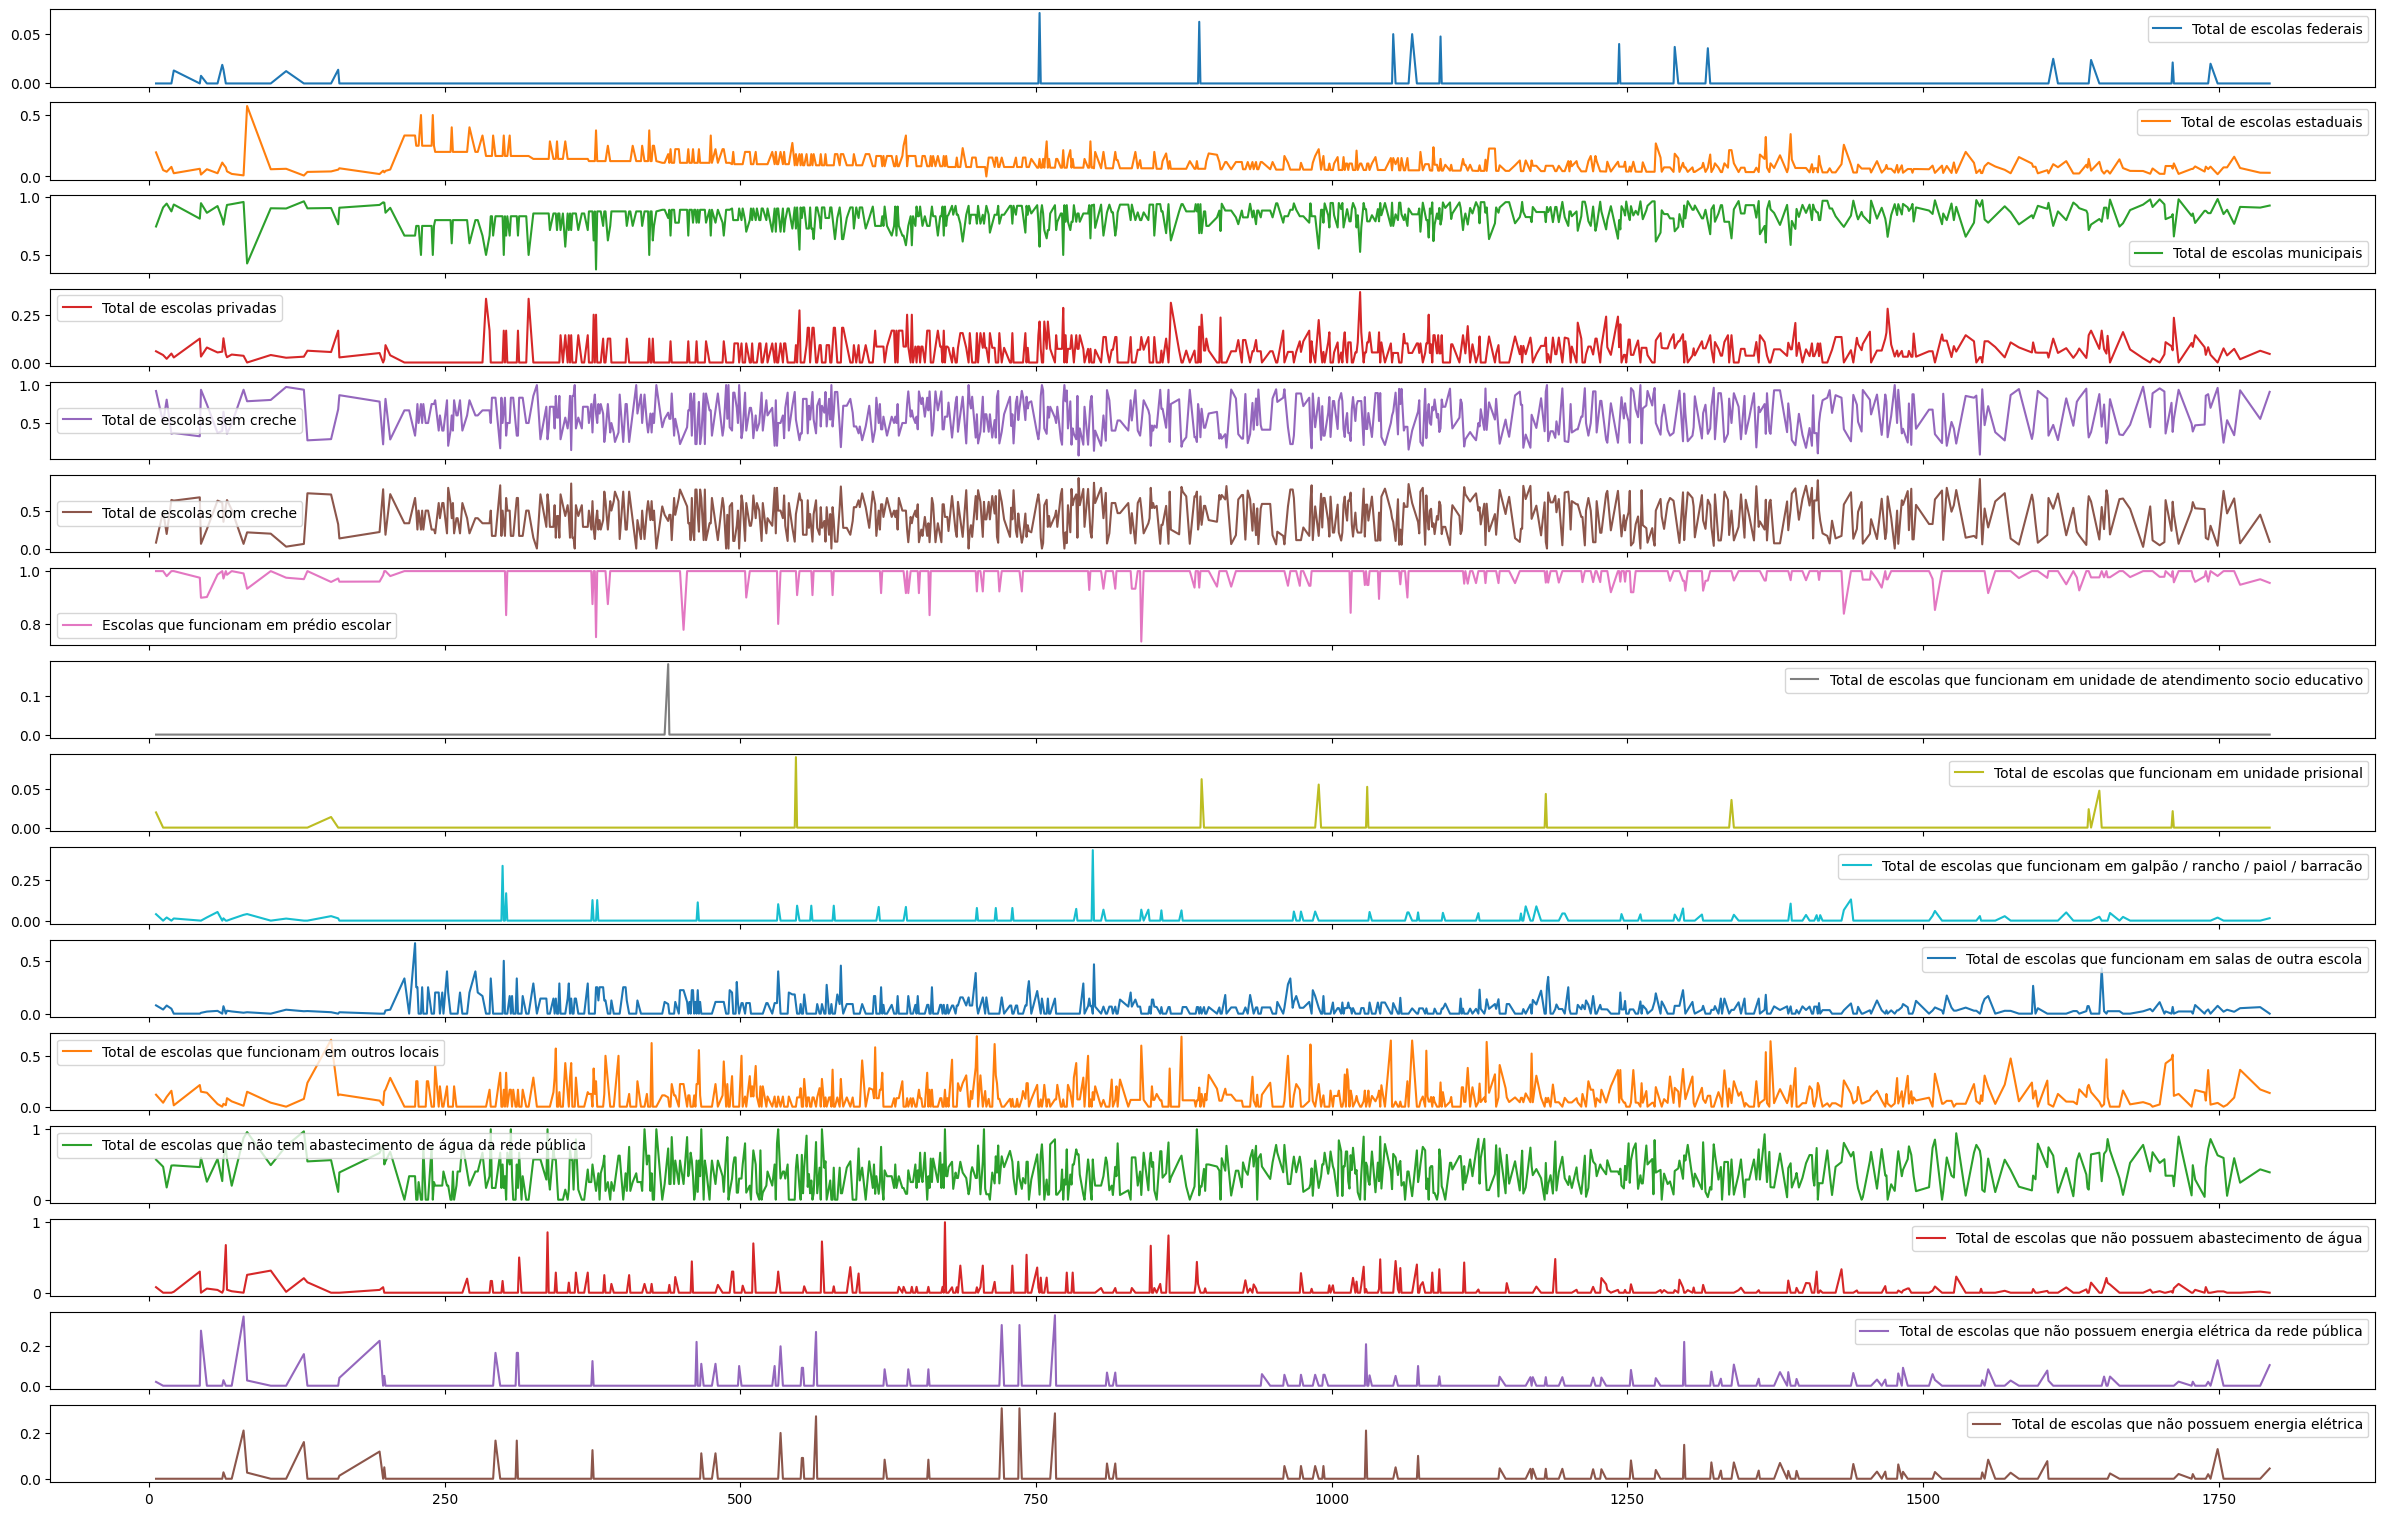

In [325]:
QEdu_2019_taxa.plot(subplots=True, layout=(25, 1), figsize=(30, 30))

In [326]:
# Calcule a média 
media_escolas_predio_escolar = QEdu_2019_taxa['Escolas que funcionam em prédio escolar'].mean()
media_escolas_agua = QEdu_2019_taxa['Total de escolas que não possuem abastecimento de água'].mean()
media_escolas_energia = QEdu_2019_taxa['Total de escolas que não possuem energia elétrica'].mean()
print(f'Médias: escolas em prédio escolar: {media_escolas_predio_escolar}, abastecimente de água: {media_escolas_agua}, energia: {media_escolas_energia}')
# Ideia: Filtrar dados baseado na média
QEdu_2019_piores_indices = QEdu_2019_taxa[QEdu_2019_taxa['Escolas que funcionam em prédio escolar'] <= media_escolas_predio_escolar]
QEdu_2019_piores_indices = QEdu_2019_piores_indices[QEdu_2019_taxa['Total de escolas que não possuem abastecimento de água'] >= media_escolas_energia/4]
QEdu_2019_piores_indices = QEdu_2019_piores_indices[QEdu_2019_taxa['Total de escolas que não possuem energia elétrica'] >= media_escolas_agua/4]

QEdu_2019_piores_indices

Médias: escolas em prédio escolar: 0.9912073880904387, abastecimente de água: 0.034740016726521085, energia: 0.006494283340463412
/tmp/ipykernel_41/464807840.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_41/464807840.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Cidade  Total de escolas federais  \
63                   Pedro II                   0.014085   
83       Carnaubeira da Penha                   0.000000   
131   Campo Alegre de Lourdes                   0.000000   
195                   Remanso                   0.000000   
817                      Patu                   0.000000   
1221                  Serrita                   0.000000   
1253                    Itagi                   0.000000   
1510                   Manari                   0.000000   
1605             Encruzilhada                   0.000000   
1658          Pedro Alexandre                   0.000000   
1749        Itaguaçu da Bahia                   0.000000   

      Total de escolas estaduais  Total de escolas municipais  \
63                      0.098592                     0.760563   
83                      0.573333                     0.426667   
131                     0.007634                     0.961832   
195                     0.019802                     0.930693   
817                     0.200000                     0.666667   
1221                    0.041667                     0.916667   
1253                    0.040000                     0.920000   
1510                    0.029412                     0.970588   
1605                    0.051282                     0.897436   
1658                    0.023256                     0.976744   
1749                    0.018519                     0.981481   

      Total de escolas privadas  Total de escolas sem creche  \
63                     0.126761                     0.647887   
83                     0.000000                     0.786667   
131                    0.030534                     0.938931   
195                    0.049505                     0.782178   
817                    0.133333                     0.400000   
1221                   0.041667                     0.916667   
1253                   0.040000                     0.960000   
1510                   0.000000                     0.352941   
1605                   0.051282                     0.820513   
1658                   0.000000                     0.813953   
1749                   0.000000                     0.962963   

      Total de escolas com creche  Escolas que funcionam em prédio escolar  \
63                       0.352113                                 0.971831   
83                       0.213333                                 0.933333   
131                      0.061069                                 0.969466   
195                      0.217822                                 0.960396   
817                      0.600000                                 0.933333   
1221                     0.083333                                 0.958333   
1253                     0.040000                                 0.920000   
1510                     0.647059                                 0.852941   
1605                     0.179487                                 0.974359   
1658                     0.186047                                 0.976744   
1749                     0.037037                                 0.981481   

      Total de escolas que funcionam em unidade de atendimento socio educativo  \
63                                                  0.0                          
83                                                  0.0                          
131                                                 0.0                          
195                                                 0.0                          
817                                                 0.0                          
1221                                                0.0                          
1253                                                0.0                          
1510                                                0.0                          
1605                                                0.0                      

In [327]:
# Gráfico de Barras para Escolas por Quantidade de Municípios por UF
plt.figure(figsize=(12, 6))
sns.barplot(x='UF', y='Escolas federais por Município', data=QEdu_2019_somas)
plt.xlabel('UF')
plt.ylabel('Escolas por Município')
plt.title('Número de Escolas Federais por Quantidade de Municípios por UF')
plt.xticks(rotation=45)
plt.show()


NameError: name 'QEdu_2019_somas' is not defined

<Figure size 1200x600 with 0 Axes>

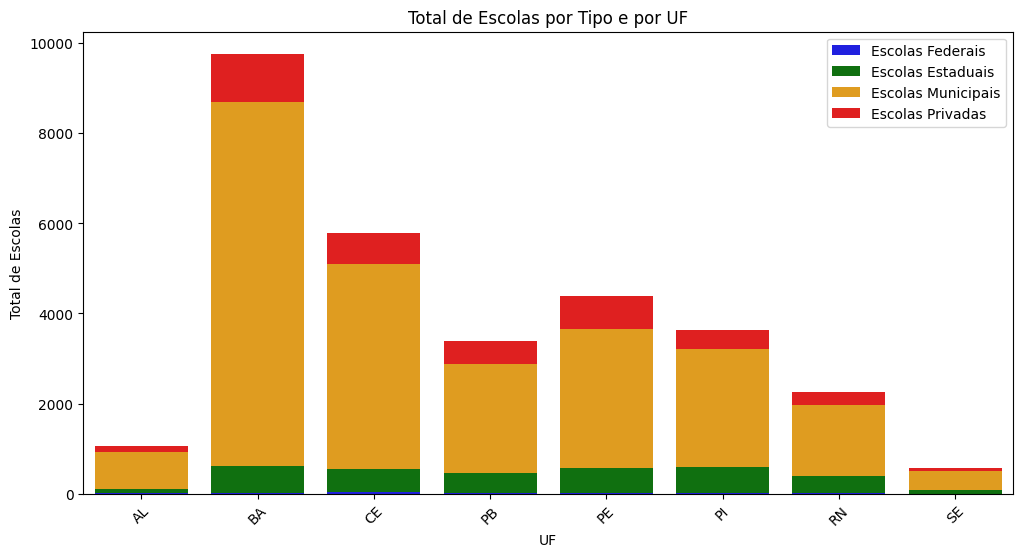

In [ ]:
# dados = QEdu_2019_somas[['UF', 'Total de escolas federais', 'Total de escolas estaduais', 'Total de escolas municipais', 'Total de escolas privadas']]

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x='UF', y='Total de escolas federais', data=dados, label='Escolas Federais', color='blue')
# ax = sns.barplot(x='UF', y='Total de escolas estaduais', data=dados, label='Escolas Estaduais', bottom=dados['Total de escolas federais'], color='green')
# ax = sns.barplot(x='UF', y='Total de escolas municipais', data=dados, label='Escolas Municipais', bottom=dados['Total de escolas federais'] + dados['Total de escolas estaduais'], color='orange')
# ax = sns.barplot(x='UF', y='Total de escolas privadas', data=dados, label='Escolas Privadas', bottom=dados['Total de escolas federais'] + dados['Total de escolas estaduais'] + dados['Total de escolas municipais'], color='red')

# plt.xlabel('UF')
# plt.ylabel('Total de Escolas')
# plt.title('Total de Escolas por Tipo e por UF')
# plt.xticks(rotation=45)
# plt.legend()

# plt.show()

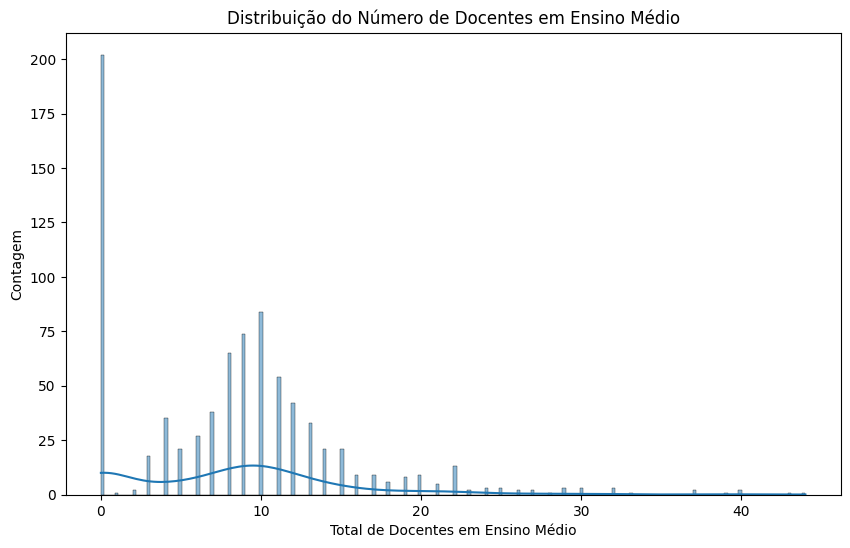

In [260]:
# Histograma Docentes ensino médio
plt.figure(figsize=(10, 6))
sns.histplot(QEdu_2019_filtrado['Total de docentes em Ensino Médio'], bins=200, kde=True)
plt.xlabel('Total de Docentes em Ensino Médio')
plt.ylabel('Contagem')
plt.title('Distribuição do Número de Docentes em Ensino Médio')

plt.show()

## 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b6e046c8-57b3-47c6-bce9-1538a03fcdec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>